# Data Modeling para Histórico de Leads

## **Introducción**

Este notebook está diseñado exclusivamente para realizar el proceso de **data modeling** sobre el histórico de leads generado. La finalidad de este flujo es transformar y preparar los datos sintéticos para que sean compatibles con los modelos de Machine Learning previamente entrenados.

El enfoque principal de este notebook es:
- **Preprocesamiento de Datos**: Aplicar las mismas transformaciones realizadas en los datos de entrenamiento, incluyendo limpieza, codificación y generación de nuevas columnas (features).
- **Selección de Features**: Filtrar únicamente las columnas relevantes utilizadas durante el entrenamiento de los modelos.
- **Exportación de Datos**: Generar un dataset final preprocesado, listo para ser utilizado en las predicciones del modelo de ML.

## **Estructura del Notebook**

1. **Cargar el Dataset Sintético**: Importar el histórico generado, que incluye datos sintéticos con un campo de fecha ajustado al volumen real.
2. **Preprocesamiento de Datos**: Realizar los pasos necesarios para limpiar y transformar los datos, asegurando la compatibilidad con los modelos.
3. **Selección de Features**: Seleccionar las columnas finales que los modelos esperan recibir.
4. **Exportación del Dataset Final**: Guardar los datos preprocesados en un archivo CSV listo para predicciones.

## **Nota Importante**

Este notebook **no incluye entrenamiento de modelos** ni análisis de métricas. Su único propósito es garantizar que el dataset sintético se ajuste al formato y las características requeridas por los modelos de Machine Learning entrenados.

¡Comencemos con el preprocesamiento de datos! 🚀



In [1]:
#Importar librerias
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import io
import os
from google.cloud import bigquery
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import precision_recall_curve
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
# Importar librerías necesarias
from google.cloud import storage, bigquery
import os
import pandas as pd
import io

# Configuración del bucket y credenciales
BUCKET_NAME = "tfg_credencial"
CREDENTIALS_FILE = "tfg-key.json"
#--------Linux o Mac------- Descomentar
#LOCAL_CREDENTIALS_PATH = "/tmp/credentials.json"

#--------Windows------- Descomentar
LOCAL_CREDENTIALS_PATH = r"C:\Users\DYLAN\Desktop\tfg-key.json"


# Función para descargar credenciales desde GCS
def download_credentials():
    if not os.path.exists(LOCAL_CREDENTIALS_PATH):
        client = storage.Client()
        bucket = client.bucket(BUCKET_NAME)
        blob = bucket.blob(CREDENTIALS_FILE)

        print("Descargando credenciales desde GCS...")
        blob.download_to_filename(LOCAL_CREDENTIALS_PATH)
        print("Credenciales descargadas y guardadas en:", LOCAL_CREDENTIALS_PATH)
    else:
        print("Credenciales ya existen en el sistema.")

    # Configurar credenciales en la variable de entorno
    os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = LOCAL_CREDENTIALS_PATH
    print("Credenciales configuradas en GOOGLE_APPLICATION_CREDENTIALS.")

# Llamar a la función para descargar credenciales
download_credentials()

# Inicializar el cliente de BigQuery
client = bigquery.Client()

# Nombre de la tabla en BigQuery
table_id = "future-loader-433707-h4.leads.cleaned_historic"

# Consultar los datos de la tabla
query = f"SELECT * FROM `{table_id}`"

try:
    # Ejecutar la consulta y convertir el resultado a un DataFrame
    query_job = client.query(query)
    df = query_job.result().to_dataframe()

    # Guardar el DataFrame en un archivo CSV en memoria
    memory_file = io.StringIO()
    df.to_csv(memory_file, index=False)
    memory_file.seek(0)

    # Leer el archivo en memoria nuevamente como un DataFrame
    data_frame_leads = pd.read_csv(memory_file)
    print("Tabla cargada en memoria y leída en una variable temporal (DataFrame).")
except Exception as e:
    print(f"Error al descargar la tabla: {e}")

# Configuración para mejorar la visualización del DataFrame
pd.set_option('display.max_columns', None)  # Muestra todas las columnas
pd.set_option('display.max_rows', 20)       # Número de filas (ajustable)
pd.set_option('display.width', 1000)        # Evitar saltos de línea
print(data_frame_leads.head())  # Imprimir las primeras filas formateadas


Credenciales ya existen en el sistema.
Credenciales configuradas en GOOGLE_APPLICATION_CREDENTIALS.


c:\Users\DYLAN\anaconda3\envs\entornoConda\lib\site-packages\google\cloud\bigquery\table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


Tabla cargada en memoria y leída en una variable temporal (DataFrame).
     Prospect ID  Lead Number              Lead Origin     Lead Source               Do Not Email  Do Not Call  Converted  Total Time Spent on Website  Page Views Per Visit            Last Activity How did you hear about X Education What is your current occupation What matters most to you in choosing a course  Search  Magazine  Newspaper Article  X Education Forums  Newspaper  Digital Advertisement  Through Recommendations  Receive More Updates About Our Courses                         Tags      Lead Quality  Update me on Supply Chain Content  Get updates on DM Content    Lead Profile          City Asymmetrique Activity Index Asymmetrique Profile Index  Asymmetrique Activity Score  Asymmetrique Profile Score  I agree to pay the amount through cheque  A free copy of Mastering The Interview Last Notable Activity        Date  TotalVisits Country                     Specialization  Average Time Per Visit     rn
0  sdv-i

C:\Users\DYLAN\AppData\Local\Temp\ipykernel_6596\3056650858.py:57: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  data_frame_leads = pd.read_csv(memory_file)


 # **1.Preparación del Dataset**: 

In [3]:
#Revisión general del data frame
print(data_frame_leads.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170503 entries, 0 to 170502
Data columns (total 40 columns):
 #   Column                                         Non-Null Count   Dtype  
---  ------                                         --------------   -----  
 0   Prospect ID                                    170503 non-null  object 
 1   Lead Number                                    170503 non-null  int64  
 2   Lead Origin                                    170503 non-null  object 
 3   Lead Source                                    169898 non-null  object 
 4   Do Not Email                                   170503 non-null  object 
 5   Do Not Call                                    170503 non-null  bool   
 6   Converted                                      170503 non-null  int64  
 7   Total Time Spent on Website                    170503 non-null  int64  
 8   Page Views Per Visit                           170503 non-null  float64
 9   Last Activity                        

In [4]:
print(data_frame_leads.isnull().sum())

Prospect ID                   0
Lead Number                   0
Lead Origin                   0
Lead Source                 605
Do Not Email                  0
                          ...  
TotalVisits                   0
Country                       0
Specialization                0
Average Time Per Visit    23448
rn                            0
Length: 40, dtype: int64


In [5]:
data_frame_leads.dtypes

Prospect ID                object
Lead Number                 int64
Lead Origin                object
Lead Source                object
Do Not Email               object
                           ...   
TotalVisits               float64
Country                    object
Specialization             object
Average Time Per Visit    float64
rn                          int64
Length: 40, dtype: object

In [6]:
data_frame_leads.describe()

,Lead Number,Converted,Total Time Spent on Website,Page Views Per Visit,Asymmetrique Activity Score,Asymmetrique Profile Score,TotalVisits,Average Time Per Visit,rn
count,170503.000000,170503.000000,170503.000000,170503.000000,92464.000000,92218.000000,170503.000000,147055.000000,170503.000000
mean,549504.911702,0.402016,271.842525,1.535069,14.269034,16.345703,2.136432,97.400038,44263.213234
std,260346.916733,0.490307,378.263760,1.559383,1.036372,1.813199,1.706724,95.459651,27249.399963
min,100002.000000,0.000000,1.000000,0.000000,10.000000,11.000000,0.000000,0.500000,1.000000
25%,323290.000000,0.000000,10.000000,0.290000,14.000000,15.000000,1.000000,19.500000,21313.500000
50%,550179.000000,0.000000,84.000000,0.920000,14.000000,16.000000,2.000000,68.000000,42626.000000
75%,774903.000000,1.000000,400.000000,2.380000,15.000000,18.000000,3.000000,151.333333,63939.000000
max,999996.000000,1.000000,2143.000000,6.000000,18.000000,20.000000,10.000000,1264.000000,101958.000000


**Borrar campo Prospect ID**

In [7]:
data_frame_leads.drop(['Prospect ID'], axis=1, inplace=True)

In [8]:
print(data_frame_leads['Specialization'].value_counts())

print("------------------------REVISAR PORCENTAJES DE SELECT EN LA COLUMNA DE SPECIALIZATION-----------------------------")

porcentaje_select = (data_frame_leads['Specialization'] == 'Select').mean() * 100
print(f"Porcentaje de 'Select': {porcentaje_select:.2f}%")

print("------------------------------------------ANALISIS DE LA TASA DE CONVERSION----------------------------------------")

conversion_select = data_frame_leads[data_frame_leads['Specialization'] == 'Select']['Converted'].mean()
print(f"Tasa de conversión para 'Select': {conversion_select:.2f}")


Specialization
Select                               38540
Finance Management                   19322
Human Resource Management            16752
Marketing Management                 16731
Unknown                              15552
Operations Management                10062
Business Administration               7972
IT Projects Management                7311
Supply Chain Management               6990
Banking, Investment And Insurance     6745
Travel and Tourism                    4025
Media and Advertising                 4007
International Business                3598
Healthcare Management                 3107
Hospitality Management                2261
E-COMMERCE                            2185
Retail Management                     1998
Rural and Agribusiness                1395
E-Business                            1125
Services Excellence                    825
Name: count, dtype: int64
------------------------REVISAR PORCENTAJES DE SELECT EN LA COLUMNA DE SPECIALIZATION--------------

Si el modelo aprende que los leads con "Select" tienen una tasa de conversión extremadamente baja, solo estará utilizando este dato como un indicador trivial y no como una característica que realmente aporte valor para predecir conversiones en general.

Esto podría derivar en un modelo que:

Detecte patrones obvios: Como "Si Specialization = Select, entonces conversión ≈ 0".
Pierda generalización: Porque el modelo no estaría aprendiendo sobre las características relevantes de los leads que realmente convierten.

In [9]:
# Eliminar filas donde 'Specialization' sea 'Select'
data_frame_leads = data_frame_leads[data_frame_leads['Specialization'] != 'Select']

# Verificar el tamaño del dataset después
print(f"Cantidad de filas después de eliminar 'Select': {len(data_frame_leads)}")


Cantidad de filas después de eliminar 'Select': 131963


In [10]:
# Verificar columnas con valores nulos
print(data_frame_leads.isnull().sum())

print("--------------COLUMNAS CON UN VALOR ALTO DE NULOS---------------")
# Analizar el porcentaje de valores nulos por columna
percent_missing = (data_frame_leads.isnull().sum() / len(data_frame_leads)) * 100
print(percent_missing)

#Analizando el volumen de nulos que tienen las columnas y viendo que no nos van  a aportar nada a los modeos de Machine Learning se van a eliminar las columnas con un 40 por ciento de valore nulos

# Eliminar columnas con más del 40% de valores nulos
columns_to_drop = percent_missing[percent_missing > 40].index
data_frame_leads.drop(columns=columns_to_drop, axis=1, inplace=True)
print(f"Columnas eliminadas: {list(columns_to_drop)}")




Lead Number                   0
Lead Origin                   0
Lead Source                 474
Do Not Email                  0
Do Not Call                   0
                          ...  
TotalVisits                   0
Country                       0
Specialization                0
Average Time Per Visit    18119
rn                            0
Length: 39, dtype: int64
--------------COLUMNAS CON UN VALOR ALTO DE NULOS---------------
Lead Number                0.000000
Lead Origin                0.000000
Lead Source                0.359192
Do Not Email               0.000000
Do Not Call                0.000000
                            ...    
TotalVisits                0.000000
Country                    0.000000
Specialization             0.000000
Average Time Per Visit    13.730364
rn                         0.000000
Length: 39, dtype: float64
Columnas eliminadas: ['Lead Quality', 'Asymmetrique Activity Index', 'Asymmetrique Profile Index', 'Asymmetrique Activity Score', 'Asym

In [11]:
# Reemplazar valores nulos en columnas categóricas y numéricas
data_frame_leads['City'].fillna('Unknown', inplace=True)
data_frame_leads['What is your current occupation'].fillna('Unknown', inplace=True)
data_frame_leads['Tags'].fillna('Unknown', inplace=True)

# Para numéricos, utilizar la media
data_frame_leads['Page Views Per Visit'].fillna(data_frame_leads['Page Views Per Visit'].mean(), inplace=True)
data_frame_leads['Last Activity'].fillna('Unknown', inplace=True)

print("Valores nulos reemplazados correctamente.")


Valores nulos reemplazados correctamente.


In [12]:
# Eliminar filas con valores nulos en columnas críticas
data_frame_leads.dropna(subset=['Lead Source'], inplace=True)
print(f"Cantidad de filas después de eliminar filas con nulos: {len(data_frame_leads)}")

#Poner la media en los pocos valores nulos que hay en la dimension Average Time Per Visit
data_frame_leads['Average Time Per Visit'].fillna(data_frame_leads['Average Time Per Visit'].mean(), inplace=True)


print("-------------------------------------VALIDAR QUE NO QUEDAN VALORES NULOS--------------------------------")

# Verificar que no quedan valores nulos
print(data_frame_leads.isnull().sum())



Cantidad de filas después de eliminar filas con nulos: 131489
-------------------------------------VALIDAR QUE NO QUEDAN VALORES NULOS--------------------------------
Lead Number               0
Lead Origin               0
Lead Source               0
Do Not Email              0
Do Not Call               0
                         ..
TotalVisits               0
Country                   0
Specialization            0
Average Time Per Visit    0
rn                        0
Length: 34, dtype: int64


# **1.1 Analisis mediante graficas de cada dimension**

**LEAD ORIGIN**

In [13]:
data_frame_leads['Lead Origin'].unique()

array(['Lead Add Form', 'API', 'Landing Page Submission', 'Lead Import',
       'Quick Add Form'], dtype=object)

In [14]:
data_frame_leads['Lead Origin'].value_counts()

Lead Origin
Landing Page Submission    70516
API                        49646
Lead Add Form              10473
Lead Import                  843
Quick Add Form                11
Name: count, dtype: int64

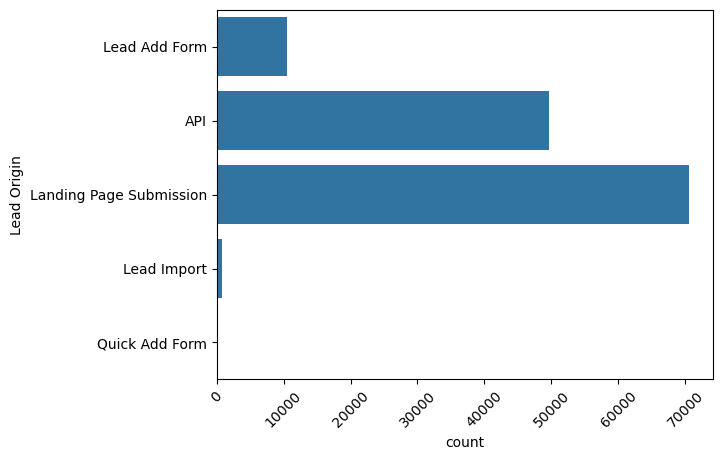

In [15]:
sns.countplot(data_frame_leads['Lead Origin'])
plt.xticks(rotation=45)
plt.show()

**Lead Source**

In [16]:
data_frame_leads['Lead Source'].unique()

array(['Direct Traffic', 'Olark Chat', 'Google', 'Organic Search',
       'Reference', 'Welingak Website', 'Facebook', 'Referral Sites',
       'bing', 'blog', 'google', 'NC_EDM', 'Click2call', 'WeLearn',
       'Social Media', 'welearnblog_Home', 'Press_Release', 'testone',
       'Pay per Click Ads', 'Live Chat', 'youtubechannel'], dtype=object)

In [17]:
data_frame_leads['Lead Source'].value_counts()

Lead Source
Google              43226
Direct Traffic      37589
Olark Chat          21829
Organic Search      16181
Reference            7649
                    ...  
welearnblog_Home       13
testone                13
WeLearn                11
youtubechannel         11
NC_EDM                  7
Name: count, Length: 21, dtype: int64

In [18]:
data_frame_leads['Lead Source'] = data_frame_leads['Lead Source'].fillna("Google")

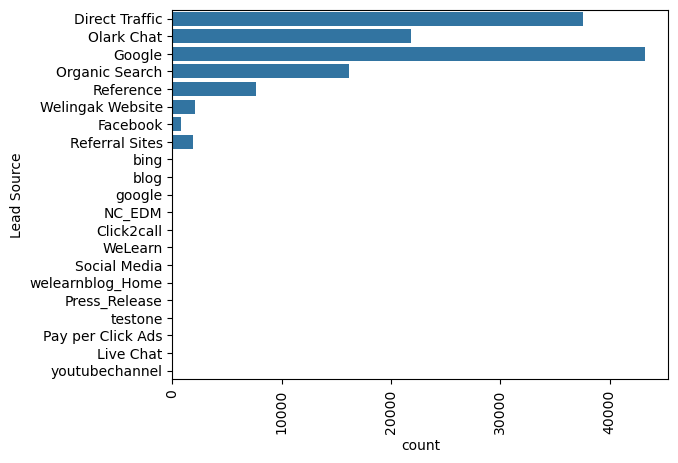

In [19]:
sns.countplot(data_frame_leads['Lead Source'])
plt.xticks(rotation=90)
plt.show()

In [20]:
#Revisando por porcentaje de distribución
LeadSourceCol=(data_frame_leads['Lead Source'].value_counts()*100)/data_frame_leads.shape[0]
LeadSourceCol

Lead Source
Google              32.874233
Direct Traffic      28.587182
Olark Chat          16.601389
Organic Search      12.305972
Reference            5.817217
                      ...    
welearnblog_Home     0.009887
testone              0.009887
WeLearn              0.008366
youtubechannel       0.008366
NC_EDM               0.005324
Name: count, Length: 21, dtype: float64

In [21]:
#Cargar columnas que tengan menos de 10% de los valores
LeadSourceCol=LeadSourceCol[LeadSourceCol<10]
LeadSourceCol

Lead Source
Reference            5.817217
Welingak Website     1.578079
Referral Sites       1.405441
Facebook             0.567348
google               0.054757
bing                 0.051715
Click2call           0.034984
Social Media         0.023576
Live Chat            0.016731
Press_Release        0.015210
Pay per Click Ads    0.012929
blog                 0.011408
welearnblog_Home     0.009887
testone              0.009887
WeLearn              0.008366
youtubechannel       0.008366
NC_EDM               0.005324
Name: count, dtype: float64

Como vemos hay muchas columnas que no nos aportan nada porque aparecen muy muy pocas veces, por lo que lo suyo es construir un dato llamado " other source" que las haga referencia a ellas.

In [22]:
for i in LeadSourceCol.index:
    data_frame_leads.loc[(data_frame_leads['Lead Source'] == i),'Lead Source']='Other Source'

In [23]:
#Revisando porcentajes de distribucion para corrobar que hemos reducido el ruido de esta columna
(data_frame_leads['Lead Source'].value_counts()*100)/data_frame_leads.shape[0]

Lead Source
Google            32.874233
Direct Traffic    28.587182
Olark Chat        16.601389
Organic Search    12.305972
Other Source       9.631224
Name: count, dtype: float64

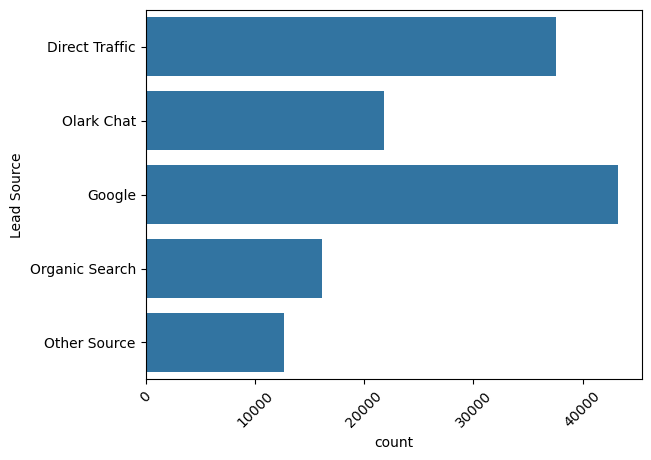

In [24]:
sns.countplot(data_frame_leads['Lead Source'])
plt.xticks(rotation=45)
plt.show()

**Last Activity**

In [25]:
data_frame_leads['Last Activity'].unique()

array(['Email Opened', 'SMS Sent', 'Page Visited on Website',
       'Olark Chat Conversation', 'Email Bounced', 'Converted to Lead',
       'Email Link Clicked', 'Form Submitted on Website', 'Unknown',
       'Unsubscribed', 'Had a Phone Conversation', 'Unreachable',
       'View in browser link Clicked', 'Email Received',
       'Approached upfront', 'Resubscribed to emails',
       'Email Marked Spam', 'Visited Booth in Tradeshow'], dtype=object)

In [26]:
data_frame_leads['Last Activity'].value_counts()

Last Activity
Email Opened                    48758
SMS Sent                        39267
Olark Chat Conversation         13684
Page Visited on Website          9212
Converted to Lead                6072
Email Bounced                    4671
Email Link Clicked               3757
Form Submitted on Website        1665
Unknown                          1499
Unreachable                      1275
Unsubscribed                      910
Had a Phone Conversation          432
Approached upfront                115
View in browser link Clicked       92
Email Received                     31
Resubscribed to emails             17
Email Marked Spam                  17
Visited Booth in Tradeshow         15
Name: count, dtype: int64

In [27]:
#Llenamos posibles nulos con el valor mas comun en la columna Last Activity
data_frame_leads['Last Activity'] = data_frame_leads['Last Activity'].replace(np.nan, 'Email Opened')

In [28]:
data_frame_leads['Last Activity'].value_counts()

Last Activity
Email Opened                    48758
SMS Sent                        39267
Olark Chat Conversation         13684
Page Visited on Website          9212
Converted to Lead                6072
Email Bounced                    4671
Email Link Clicked               3757
Form Submitted on Website        1665
Unknown                          1499
Unreachable                      1275
Unsubscribed                      910
Had a Phone Conversation          432
Approached upfront                115
View in browser link Clicked       92
Email Received                     31
Resubscribed to emails             17
Email Marked Spam                  17
Visited Booth in Tradeshow         15
Name: count, dtype: int64

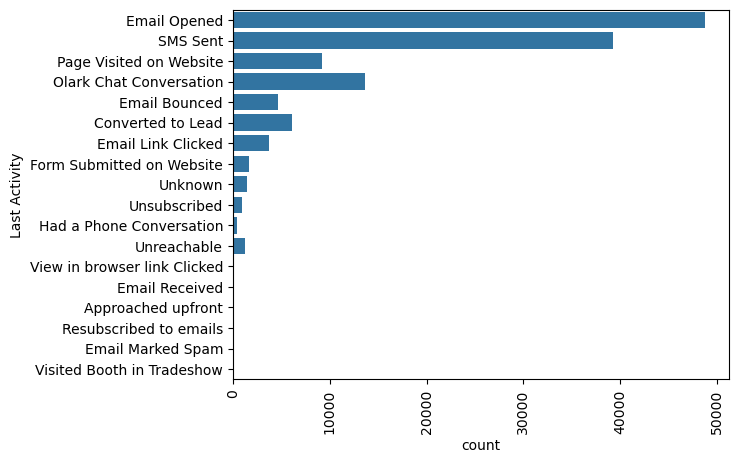

In [29]:
sns.countplot(data_frame_leads['Last Activity'])
plt.xticks(rotation=90)
plt.show()

In [30]:
#Revisando el porcentaje de distribucion de esta columna
LastActivityCol=(data_frame_leads['Last Activity'].value_counts()*100)/data_frame_leads.shape[0]
LastActivityCol

Last Activity
Email Opened                    37.081429
SMS Sent                        29.863335
Olark Chat Conversation         10.406954
Page Visited on Website          7.005909
Converted to Lead                4.617877
Email Bounced                    3.552388
Email Link Clicked               2.857273
Form Submitted on Website        1.266266
Unknown                          1.140019
Unreachable                      0.969663
Unsubscribed                     0.692073
Had a Phone Conversation         0.328545
Approached upfront               0.087460
View in browser link Clicked     0.069968
Email Received                   0.023576
Resubscribed to emails           0.012929
Email Marked Spam                0.012929
Visited Booth in Tradeshow       0.011408
Name: count, dtype: float64

In [31]:
#Last Activity Columns having less than 5% values
LastActivityCol=LastActivityCol[LastActivityCol<5]
LastActivityCol

Last Activity
Converted to Lead               4.617877
Email Bounced                   3.552388
Email Link Clicked              2.857273
Form Submitted on Website       1.266266
Unknown                         1.140019
Unreachable                     0.969663
Unsubscribed                    0.692073
Had a Phone Conversation        0.328545
Approached upfront              0.087460
View in browser link Clicked    0.069968
Email Received                  0.023576
Resubscribed to emails          0.012929
Email Marked Spam               0.012929
Visited Booth in Tradeshow      0.011408
Name: count, dtype: float64

In [32]:
for i in LastActivityCol.index:
    data_frame_leads.loc[(data_frame_leads['Last Activity'] == i),'Last Activity']='Other Last Activity'

In [33]:
#Checking for percantage of distibution
(data_frame_leads['Last Activity'].value_counts()*100)/data_frame_leads.shape[0]

Last Activity
Email Opened               37.081429
SMS Sent                   29.863335
Other Last Activity        15.642373
Olark Chat Conversation    10.406954
Page Visited on Website     7.005909
Name: count, dtype: float64

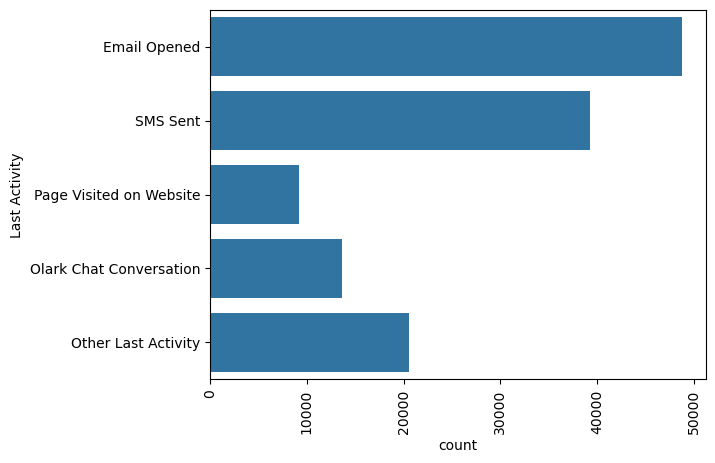

In [34]:
sns.countplot(data_frame_leads['Last Activity'])
plt.xticks(rotation=90)
plt.show()

**5.Country**

In [35]:
data_frame_leads['Country'].unique()

array(['India', 'Unknown', 'United States', 'United Arab Emirates',
       'unknown', 'Hong Kong', 'Sweden', 'Qatar', 'China', 'Singapore',
       'Saudi Arabia', 'Nigeria', 'United Kingdom', 'France', 'Canada',
       'Sri Lanka', 'South Africa', 'Oman', 'Bahrain', 'Kuwait',
       'Switzerland', 'Australia', 'Belgium', 'Russia', 'Germany',
       'Ghana', 'Asia/Pacific Region', 'Netherlands', 'Philippines',
       'Uganda', 'Italy', 'Tanzania', 'Denmark', 'Liberia', 'Bangladesh'],
      dtype=object)

In [36]:
data_frame_leads['Country'].value_counts()

Country
India                   106635
Unknown                  22928
United States              532
United Arab Emirates       462
Saudi Arabia               146
                         ...  
Philippines                  1
Tanzania                     1
Denmark                      1
Liberia                      1
Bangladesh                   1
Name: count, Length: 35, dtype: int64

In [37]:
#Los valores Na se sustituyen por el dato que mas aparece en este caso India
data_frame_leads['Country'] = data_frame_leads['Country'].fillna("India")

In [38]:
data_frame_leads['Country'].unique()

array(['India', 'Unknown', 'United States', 'United Arab Emirates',
       'unknown', 'Hong Kong', 'Sweden', 'Qatar', 'China', 'Singapore',
       'Saudi Arabia', 'Nigeria', 'United Kingdom', 'France', 'Canada',
       'Sri Lanka', 'South Africa', 'Oman', 'Bahrain', 'Kuwait',
       'Switzerland', 'Australia', 'Belgium', 'Russia', 'Germany',
       'Ghana', 'Asia/Pacific Region', 'Netherlands', 'Philippines',
       'Uganda', 'Italy', 'Tanzania', 'Denmark', 'Liberia', 'Bangladesh'],
      dtype=object)

In [39]:
data_frame_leads['Country'].value_counts()

Country
India                   106635
Unknown                  22928
United States              532
United Arab Emirates       462
Saudi Arabia               146
                         ...  
Philippines                  1
Tanzania                     1
Denmark                      1
Liberia                      1
Bangladesh                   1
Name: count, Length: 35, dtype: int64

In [40]:
# borramos la columna country porque solo  hay datos de la india y ademas el otro volumen mas cuantioso es desconocido
data_frame_leads.drop(labels='Country',axis=1,inplace=True)

**6.Specialization**

In [41]:
data_frame_leads['Specialization'].unique()

array(['Unknown', 'Supply Chain Management',
       'Banking, Investment And Insurance', 'Business Administration',
       'Human Resource Management', 'Marketing Management',
       'Travel and Tourism', 'Operations Management',
       'Finance Management', 'IT Projects Management',
       'Rural and Agribusiness', 'Healthcare Management',
       'Media and Advertising', 'Retail Management', 'E-COMMERCE',
       'International Business', 'E-Business', 'Hospitality Management',
       'Services Excellence'], dtype=object)

In [42]:
data_frame_leads['Specialization'] = data_frame_leads['Specialization'].replace(np.nan, 'Others')

In [43]:
data_frame_leads['Specialization'].value_counts()

Specialization
Finance Management                   19256
Human Resource Management            16696
Marketing Management                 16683
Unknown                              15500
Operations Management                10025
Business Administration               7944
IT Projects Management                7278
Supply Chain Management               6963
Banking, Investment And Insurance     6723
Travel and Tourism                    4010
Media and Advertising                 3988
International Business                3577
Healthcare Management                 3097
Hospitality Management                2253
E-COMMERCE                            2170
Retail Management                     1987
Rural and Agribusiness                1393
E-Business                            1121
Services Excellence                    825
Name: count, dtype: int64

In [44]:
#Checking for percantage of distibution
OtherCol=(data_frame_leads['Specialization'].value_counts()*100)/data_frame_leads.shape[0]
OtherCol

Specialization
Finance Management                   14.644571
Human Resource Management            12.697640
Marketing Management                 12.687753
Unknown                              11.788058
Operations Management                 7.624212
Business Administration               6.041570
IT Projects Management                5.535064
Supply Chain Management               5.295500
Banking, Investment And Insurance     5.112975
Travel and Tourism                    3.049685
Media and Advertising                 3.032953
International Business                2.720380
Healthcare Management                 2.355330
Hospitality Management                1.713451
E-COMMERCE                            1.650328
Retail Management                     1.511153
Rural and Agribusiness                1.059404
E-Business                            0.852543
Services Excellence                   0.627429
Name: count, dtype: float64

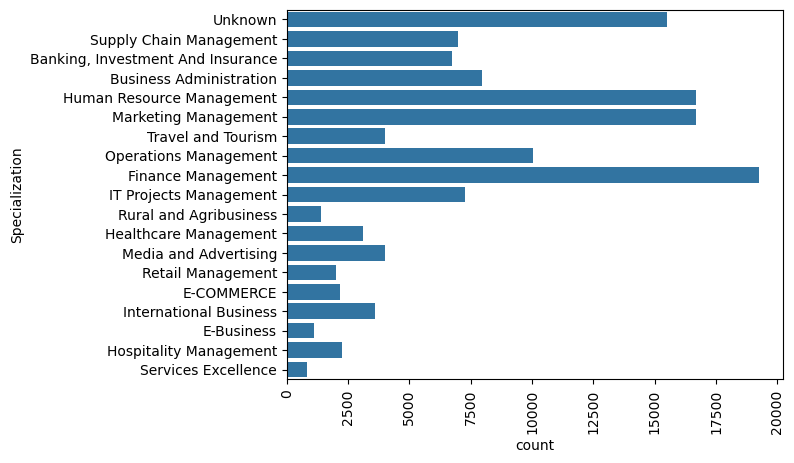

In [45]:
sns.countplot(data_frame_leads['Specialization'])
plt.xticks(rotation=90)
plt.show()

In [46]:
#Agrupamos los datos en una sola variable llamada Others cuando tienen un volumen inferior al 2% respecto a el volumen total de la columna Specialization

OtherCol=OtherCol[OtherCol<2]
for i in OtherCol.index:
    data_frame_leads.loc[(data_frame_leads['Specialization'] == i),'Specialization']='Others'
#Checking for percantage of distibution
(data_frame_leads['Specialization'].value_counts()*100)/data_frame_leads.shape[0]


Specialization
Finance Management                   14.644571
Human Resource Management            12.697640
Marketing Management                 12.687753
Unknown                              11.788058
Operations Management                 7.624212
Others                                7.414308
Business Administration               6.041570
IT Projects Management                5.535064
Supply Chain Management               5.295500
Banking, Investment And Insurance     5.112975
Travel and Tourism                    3.049685
Media and Advertising                 3.032953
International Business                2.720380
Healthcare Management                 2.355330
Name: count, dtype: float64

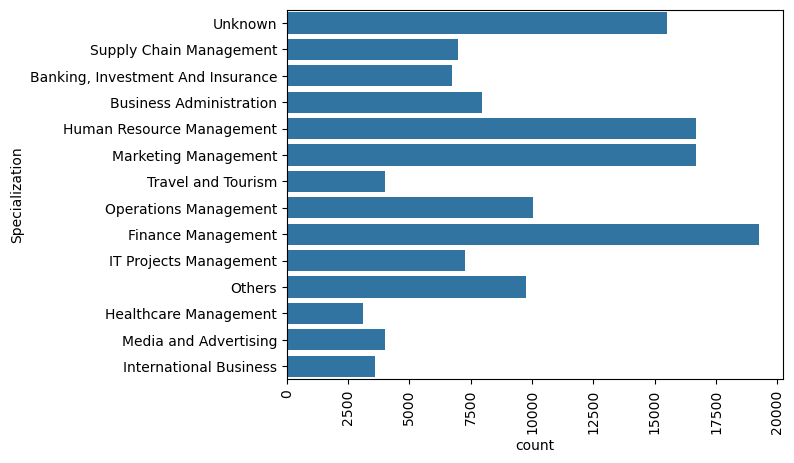

In [47]:
sns.countplot(data_frame_leads['Specialization'])
plt.xticks(rotation=90)
plt.show()

**7. WHAT IS YOUR CURRENT OCCUPATION**

In [48]:
data_frame_leads['What is your current occupation'].unique()

array(['Student', 'Unemployed', 'Unknown', 'Working Professional',
       'Businessman', 'Other', 'Housewife'], dtype=object)

In [49]:
data_frame_leads['What is your current occupation'].value_counts()

What is your current occupation
Unemployed              102610
Working Professional     12698
Unknown                  11731
Student                   3833
Other                      294
Housewife                  197
Businessman                126
Name: count, dtype: int64

In [50]:
data_frame_leads['What is your current occupation'] = data_frame_leads['What is your current occupation'].fillna("Unemployed")

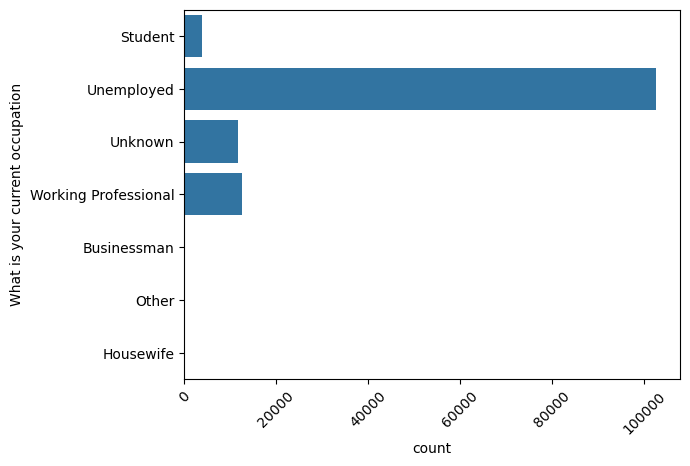

In [51]:
sns.countplot(data_frame_leads['What is your current occupation'])
plt.xticks(rotation=45)
plt.show()

In [52]:
#Revisando porcentaje de distribucion
LeadSourceCol=(data_frame_leads['What is your current occupation'].value_counts()*100)/data_frame_leads.shape[0]
LeadSourceCol

What is your current occupation
Unemployed              78.036946
Working Professional     9.657082
Unknown                  8.921659
Student                  2.915073
Other                    0.223593
Housewife                0.149822
Businessman              0.095826
Name: count, dtype: float64

**8. TAGS**

In [53]:
data_frame_leads['Tags'].unique()


array(['Unknown', 'Interested in other courses', 'Busy',
       'Already a student', 'Ringing',
       'Will revert after reading the email', 'switched off',
       'wrong number given', 'Lost to EINS',
       'Not doing further education', 'Closed by Horizzon',
       'Graduation in progress', 'invalid number', 'opp hangup',
       'Interested  in full time MBA', 'in touch with EINS',
       'Diploma holder (Not Eligible)', 'number not provided',
       'University not recognized',
       'Want to take admission but has financial problems',
       'Recognition issue (DEC approval)', 'Still Thinking',
       'Lateral student', 'Interested in Next batch', 'Lost to Others',
       'In confusion whether part time or DLP',
       'Shall take in the next coming month'], dtype=object)

In [54]:
data_frame_leads['Tags'].value_counts()

Tags
Will revert after reading the email    42005
Ringing                                24315
Unknown                                12002
Interested in other courses            10448
Already a student                       9461
                                       ...  
Interested in Next batch                  94
Lateral student                           49
Shall take in the next coming month       41
University not recognized                 37
Recognition issue (DEC approval)          19
Name: count, Length: 27, dtype: int64

In [55]:
#"Will revert after reading the email" is coming the most times , hence replacing NaN value with value this.
data_frame_leads['Tags'] = data_frame_leads['Tags'].fillna("Will revert after reading the email")

In [56]:
data_frame_leads['Tags'].value_counts()

Tags
Will revert after reading the email    42005
Ringing                                24315
Unknown                                12002
Interested in other courses            10448
Already a student                       9461
                                       ...  
Interested in Next batch                  94
Lateral student                           49
Shall take in the next coming month       41
University not recognized                 37
Recognition issue (DEC approval)          19
Name: count, Length: 27, dtype: int64

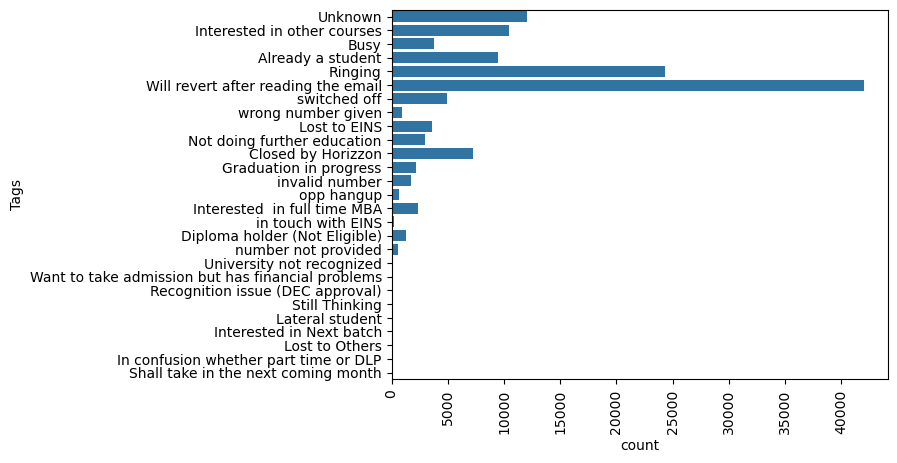

In [57]:
sns.countplot(data_frame_leads['Tags'])
plt.xticks(rotation=90)
plt.show()

In [58]:
#Checking for percantage of distibution
TagsCol=(data_frame_leads['Tags'].value_counts()*100)/data_frame_leads.shape[0]
TagsCol

Tags
Will revert after reading the email    31.945638
Ringing                                18.492041
Unknown                                 9.127760
Interested in other courses             7.945912
Already a student                       7.195279
                                         ...    
Interested in Next batch                0.071489
Lateral student                         0.037265
Shall take in the next coming month     0.031181
University not recognized               0.028139
Recognition issue (DEC approval)        0.014450
Name: count, Length: 27, dtype: float64

In [59]:
#Tags Columns que tienen menos de 3% values
TagsCol=TagsCol[TagsCol<3]
for i in TagsCol.index:
    data_frame_leads.loc[(data_frame_leads['Tags'] == i),'Tags']='Other Tags'

In [60]:
#Revisando de nuevo la distribución
(data_frame_leads['Tags'].value_counts()*100)/data_frame_leads.shape[0]

Tags
Will revert after reading the email    31.945638
Ringing                                18.492041
Other Tags                             16.050772
Unknown                                 9.127760
Interested in other courses             7.945912
Already a student                       7.195279
Closed by Horizzon                      5.487912
switched off                            3.754687
Name: count, dtype: float64

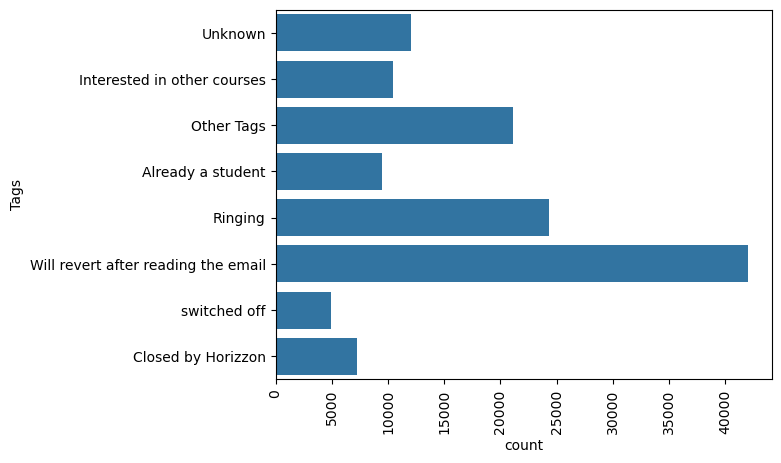

In [61]:
sns.countplot(data_frame_leads['Tags'])
plt.xticks(rotation=90)
plt.show()

**9. A FREE COPY OF MASTERING THE INTERVIEW**

In [62]:
data_frame_leads['A free copy of Mastering The Interview'].unique()

array([ True, False])

In [63]:
data_frame_leads['A free copy of Mastering The Interview'].value_counts()

A free copy of Mastering The Interview
False    88390
True     43099
Name: count, dtype: int64

C:\Users\DYLAN\AppData\Local\Temp\ipykernel_6596\4056837565.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette='muted')


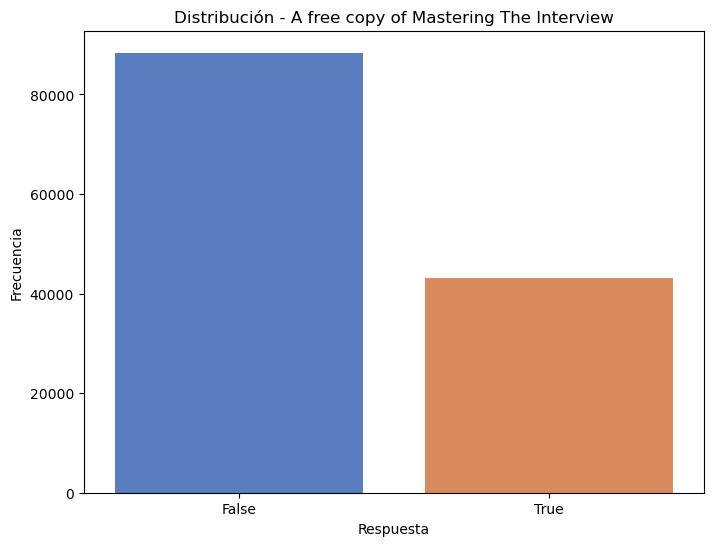

In [64]:

# Agrupar por valor y contar
counts = data_frame_leads['A free copy of Mastering The Interview'].value_counts()

# Graficar usando barplot en lugar de countplot
plt.figure(figsize=(8, 6))
sns.barplot(x=counts.index, y=counts.values, palette='muted')

# Título y etiquetas
plt.title('Distribución - A free copy of Mastering The Interview')
plt.xlabel('Respuesta')
plt.ylabel('Frecuencia')

plt.show()


**10. LAST NOTABLE ACTIVITY**

In [65]:
data_frame_leads['Last Notable Activity'].unique()

array(['Email Opened', 'Modified', 'SMS Sent', 'Email Bounced',
       'Olark Chat Conversation', 'Page Visited on Website',
       'Email Link Clicked', 'Unsubscribed', 'Had a Phone Conversation',
       'Unreachable', 'View in browser link Clicked', 'Email Received',
       'Form Submitted on Website', 'Resubscribed to emails',
       'Email Marked Spam', 'Approached upfront'], dtype=object)

In [66]:
data_frame_leads['Last Notable Activity'].value_counts()

Last Notable Activity
Modified                        48389
Email Opened                    39753
SMS Sent                        31445
Page Visited on Website          4484
Olark Chat Conversation          2558
Email Link Clicked               2500
Email Bounced                     878
Unsubscribed                      702
Unreachable                       464
Had a Phone Conversation          195
Email Marked Spam                  33
Email Received                     22
Form Submitted on Website          20
Resubscribed to emails             17
View in browser link Clicked       16
Approached upfront                 13
Name: count, dtype: int64

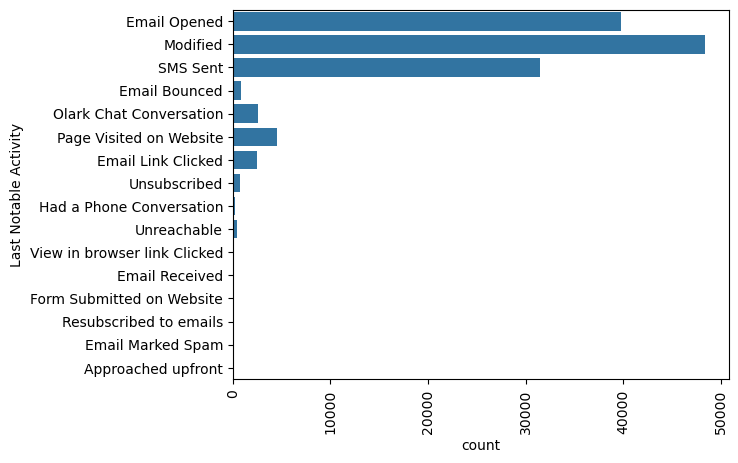

In [67]:
sns.countplot(data_frame_leads['Last Notable Activity'])
plt.xticks(rotation=90)
plt.show()

In [68]:
#Revisando el porcentaje de distribucion
OtherCol=(data_frame_leads['Last Notable Activity'].value_counts()*100)/data_frame_leads.shape[0]
OtherCol

Last Notable Activity
Modified                        36.800797
Email Opened                    30.232947
SMS Sent                        23.914548
Page Visited on Website          3.410171
Olark Chat Conversation          1.945410
Email Link Clicked               1.901300
Email Bounced                    0.667736
Unsubscribed                     0.533885
Unreachable                      0.352881
Had a Phone Conversation         0.148301
Email Marked Spam                0.025097
Email Received                   0.016731
Form Submitted on Website        0.015210
Resubscribed to emails           0.012929
View in browser link Clicked     0.012168
Approached upfront               0.009887
Name: count, dtype: float64

In [69]:
#Agrupando las variables inferiores al 5 por ciento en una sola para reducir ruido
OtherCol=OtherCol[OtherCol<5]
for i in OtherCol.index:
    data_frame_leads.loc[(data_frame_leads['Last Notable Activity'] == i),'Last Notable Activity']='Other Activity'
#Checking for percantage of distibution
(data_frame_leads['Last Notable Activity'].value_counts()*100)/data_frame_leads.shape[0]

Last Notable Activity
Modified          36.800797
Email Opened      30.232947
SMS Sent          23.914548
Other Activity     9.051708
Name: count, dtype: float64

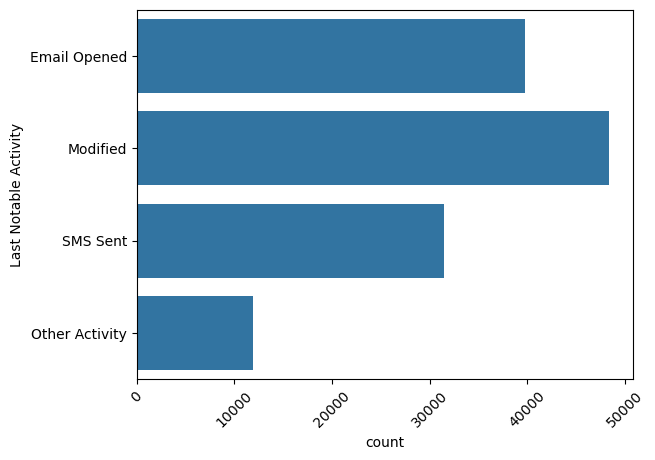

In [70]:
sns.countplot(data_frame_leads['Last Notable Activity'])
plt.xticks(rotation=45)
plt.show()

**11.CITY**

In [71]:
data_frame_leads['City'].unique()

array(['Other Cities', 'Mumbai', 'Select', 'Thane & Outskirts',
       'Other Metro Cities', 'Other Cities of Maharashtra',
       'Tier II Cities'], dtype=object)

In [72]:
data_frame_leads['City'].value_counts()

City
Mumbai                         54171
Select                         37855
Thane & Outskirts              12581
Other Cities                   11532
Other Cities of Maharashtra     7705
Other Metro Cities              6393
Tier II Cities                  1252
Name: count, dtype: int64

In [73]:
# value - Mumbai
data_frame_leads['City'] = data_frame_leads['City'].fillna("Mumbai")

In [74]:
data_frame_leads['City'].value_counts()

City
Mumbai                         54171
Select                         37855
Thane & Outskirts              12581
Other Cities                   11532
Other Cities of Maharashtra     7705
Other Metro Cities              6393
Tier II Cities                  1252
Name: count, dtype: int64

In [75]:
#Revisando el porcentaje de distribucion
data_frame_leads['City'].value_counts()*100/data_frame_leads.shape[0]

City
Mumbai                         41.198123
Select                         28.789480
Thane & Outskirts               9.568101
Other Cities                    8.770315
Other Cities of Maharashtra     5.859806
Other Metro Cities              4.862004
Tier II Cities                  0.952171
Name: count, dtype: float64

**REVISAR LOS VALORES NUMERICOS DE CADA DIMENSION**

**1.LEAD NUMBER**

count    131489.000000
mean     549684.187500
std      260359.953125
min      100002.000000
25%      323147.000000
50%      550449.000000
75%      775004.000000
max      999996.000000
Name: Lead Number, dtype: float64

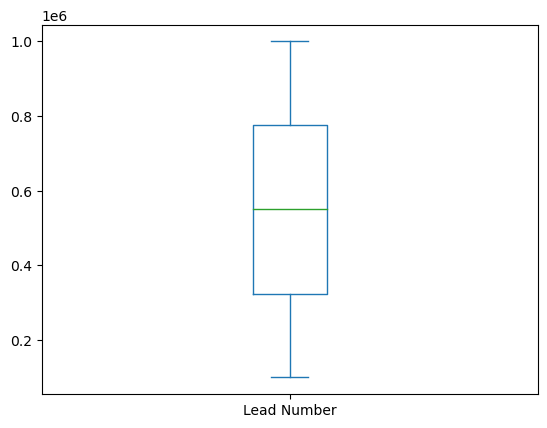

In [76]:
converted = pd.to_numeric(data_frame_leads["Lead Number"],downcast='float',errors='coerce')
converted.plot(kind='box')
converted.describe()
#Tiene sentido porque es un identificador para el lead

**2.Total Visits**

count    131489.000000
mean          2.136741
std           1.707628
min           0.000000
25%           1.000000
50%           2.000000
75%           3.000000
max          10.000000
Name: TotalVisits, dtype: float64

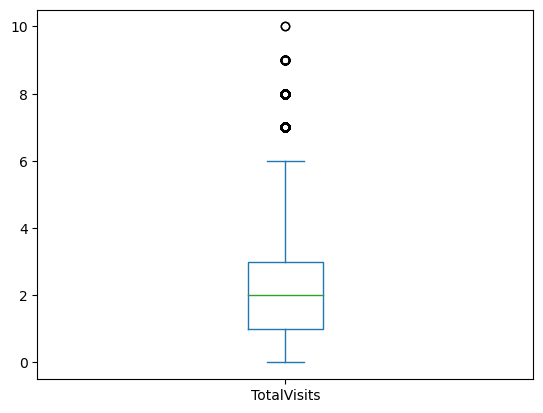

In [77]:
converted =pd.to_numeric(data_frame_leads["TotalVisits"],downcast='float',errors='coerce') # error coerce sirve para que te solicione errores si el CSV esta mal hecho.
converted.plot(kind='box')
converted.describe()

**3. Page Views Per Visit**

count    131489.000000
mean          1.533779
std           1.558869
min           0.000000
25%           0.290000
50%           0.920000
75%           2.380000
max           6.000000
Name: Page Views Per Visit, dtype: float64

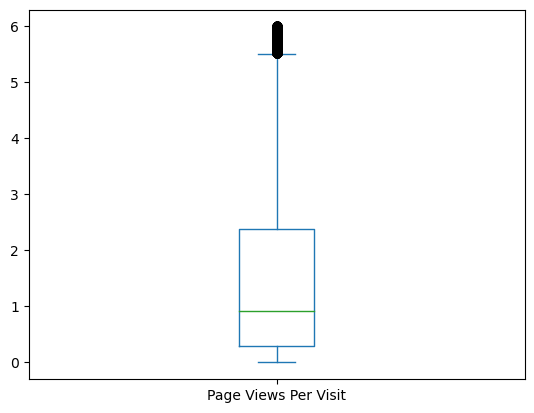

In [78]:
converted =pd.to_numeric(data_frame_leads["Page Views Per Visit"],downcast='float',errors='coerce') # error coerce sirve para que te solicione errores si el CSV esta mal hecho.
converted.plot(kind='box')
converted.describe()


**4.Total Time Spent on Website**

In [79]:
data_frame_leads['Total Time Spent on Website'].describe()

count    131489.000000
mean        271.481295
std         377.610850
min           1.000000
25%          10.000000
50%          84.000000
75%         400.000000
max        2143.000000
Name: Total Time Spent on Website, dtype: float64

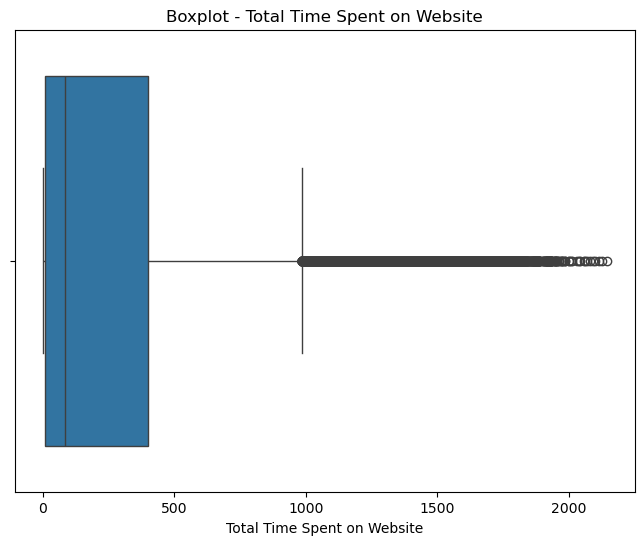

In [80]:
# Asegurar que no haya valores infinitos
data_frame_leads.replace([np.inf, -np.inf], np.nan, inplace=True)

# Eliminar valores nulos si los hay (Esto lo mantenemos para evitar errores en la visualización)
data_frame_leads.dropna(subset=['Total Time Spent on Website'], inplace=True)

# Visualización inicial con boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x=data_frame_leads['Total Time Spent on Website'])
plt.title('Boxplot - Total Time Spent on Website')
plt.show()

# Comentado: Análisis estadístico de outliers
# desc_stats = data_frame_leads['Total Time Spent on Website'].describe()
# Q1 = desc_stats['25%']
# Q3 = desc_stats['75%']
# IQR = Q3 - Q1  # Rango intercuartílico
# limite_inferior = Q1 - 1.5 * IQR
# limite_superior = Q3 + 1.5 * IQR

# print(f"Límite inferior: {limite_inferior}")
# print(f"Límite superior: {limite_superior}")

# outliers = data_frame_leads[(data_frame_leads['Total Time Spent on Website'] > limite_superior) |
#                             (data_frame_leads['Total Time Spent on Website'] < limite_inferior)]
# print(f"Número de outliers detectados: {len(outliers)}")

# Método 1: Eliminar outliers (Comentado)
# data_frame_sin_outliers = data_frame_leads[(data_frame_leads['Total Time Spent on Website'] <= limite_superior) &
#                                            (data_frame_leads['Total Time Spent on Website'] >= limite_inferior)]

# Método 2: Limitar outliers (Comentado)
# data_frame_winsorized = data_frame_leads.copy()
# data_frame_winsorized['Total Time Spent on Website'] = np.where(
#     data_frame_winsorized['Total Time Spent on Website'] > limite_superior,
#     limite_superior,
#     np.where(
#         data_frame_winsorized['Total Time Spent on Website'] < limite_inferior,
#         limite_inferior,
#         data_frame_winsorized['Total Time Spent on Website']
#     )
# )


**Explicaciones de porque se va a trabajar con outliners**
Los modelos de ML de Random Forest y XGboost no son sensibles a los datos fuera de lo común además estos datos pueden dar luz al modelo para entender cuando un usuario (lead) va a hacer una conversion, fijandose en la cantidad de tiempo que pasa en la web.

## EDA -> ANALISIS EXPLORATORIO DE DATOS ##

**UNIVARIATE ANALYSIS**

**1. Variables Categóricas**

In [81]:
data_frame_leads.dtypes

Lead Number                 int64
Lead Origin                object
Lead Source                object
Do Not Email               object
Do Not Call                  bool
                           ...   
Date                       object
TotalVisits               float64
Specialization             object
Average Time Per Visit    float64
rn                          int64
Length: 33, dtype: object

In [82]:
#Decido pasar el bool a object para mejorar la calidad del dato y comprension
# Convertir booleano a object
data_frame_leads['A free copy of Mastering The Interview'] = data_frame_leads['A free copy of Mastering The Interview'].astype(str)


In [83]:
data_frame_leads.dtypes

Lead Number                 int64
Lead Origin                object
Lead Source                object
Do Not Email               object
Do Not Call                  bool
                           ...   
Date                       object
TotalVisits               float64
Specialization             object
Average Time Per Visit    float64
rn                          int64
Length: 33, dtype: object

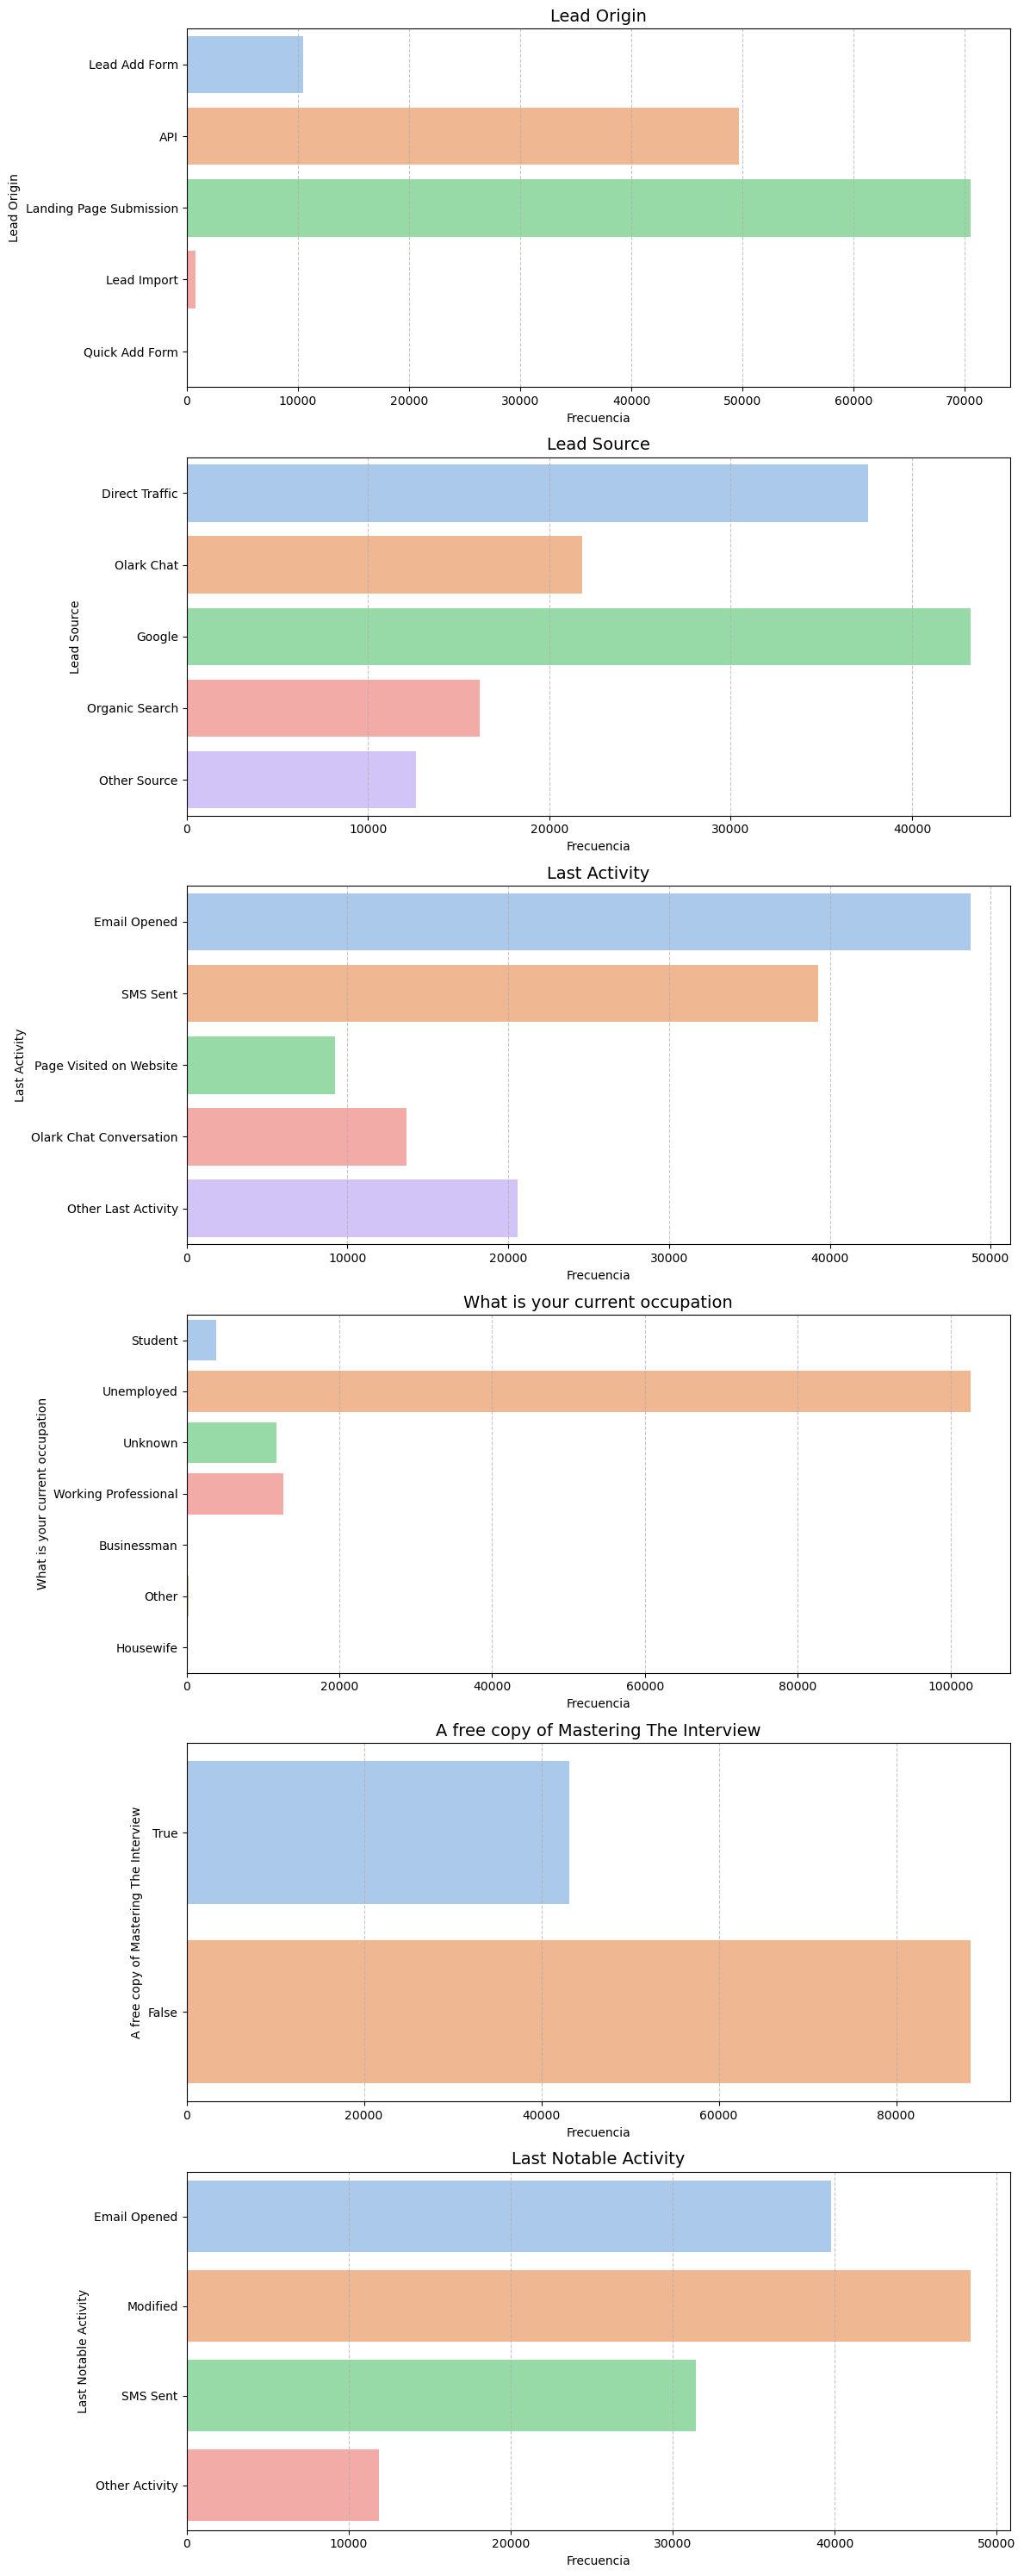

In [84]:
plt.figure(figsize=(12, 30))  # Ajustamos el tamaño para una disposición vertical

columns = [
    'Lead Origin',
    'Lead Source',
    'Last Activity',
    'What is your current occupation',
    'A free copy of Mastering The Interview',
    'Last Notable Activity'
]

# Generar gráficos verticales
for i, column in enumerate(columns, 1):
    plt.subplot(len(columns), 1, i)  # 1 columna, tantas filas como gráficas
    
    # Calcular colores basados en categorías únicas
    num_classes = data_frame_leads[column].nunique()  # Número de categorías únicas
    colors = sns.color_palette('pastel', n_colors=num_classes)  # Generar colores exactos
    
    sns.countplot(y=data_frame_leads[column], hue=data_frame_leads[column], palette=colors, legend=False)
    
    plt.title(column, fontsize=14)
    plt.xlabel('Frecuencia')  # Etiqueta del eje X
    plt.ylabel(column)  # Etiqueta del eje Y
    plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


# Observaciones del Análisis Exploratorio de Datos (EDA)

## 1. Lead Origin (Origen del Lead)
- **Observación Principal**: La mayoría de los leads provienen de "Landing Page Submission" y "API".  
- **Interpretación**:  
  - Las **páginas de aterrizaje** parecen ser la principal fuente de generación de leads.  
  - La API también es una fuente importante, lo que sugiere automatización o integración con otros sistemas.  
  - **Lead Add Form** y **Lead Import** tienen una contribución menor, lo que puede indicar que son canales menos efectivos o utilizados.

---

## 2. Lead Source (Fuente del Lead)
- **Observación Principal**: "Google" y "Direct Traffic" dominan como fuentes principales de leads.  
- **Interpretación**:  
  - El tráfico orgánico y directo representan la mayor parte de los leads.  
  - "Olark Chat" también tiene una presencia significativa, lo que sugiere que la interacción en vivo puede ser clave en la captación de leads.  
  - **Fuentes menos comunes** podrían representar nichos o esfuerzos de marketing menos efectivos.

---

## 3. Last Activity (Última Actividad)
- **Observación Principal**: "Email Opened" y "SMS Sent" son las actividades más frecuentes.  
- **Interpretación**:  
  - Los leads parecen responder más a correos electrónicos y mensajes SMS, lo que indica que estos canales son efectivos.  
  - Actividades como "Page Visited on Website" tienen menos frecuencia, pero siguen siendo relevantes.

---

## 4. What is your Current Occupation (Ocupación Actual)
- **Observación Principal**:  
  - La mayoría de los leads están **desempleados** o tienen un estado **desconocido**.  
  - "Working Professional" también representa una parte considerable.  
- **Interpretación**:  
  - El alto número de desempleados puede indicar que el producto o servicio se dirige a personas que buscan mejorar sus habilidades o encontrar trabajo.  
  - La categoría **"Unknown"** debería investigarse más a fondo, ya que podría haber falta de información relevante que afecte el análisis.

---

## 5. A Free Copy of Mastering The Interview (Copia Gratuita de "Mastering The Interview")
- **Observación Principal**:  
  - La mayoría de los leads **no** solicitan una copia gratuita.  
- **Interpretación**:  
  - Puede que el recurso no sea atractivo o no se promocione correctamente.  
  - La conversión en aquellos que sí solicitan la copia es notablemente mayor, lo que indica que este grupo tiene más interés.

---

## 6. Last Notable Activity (Última Actividad Notable)
- **Observación Principal**:  
  - Las actividades más comunes son "Email Opened" y "Modified".  
- **Interpretación**:  
  - El seguimiento por correo electrónico sigue siendo un canal crucial.  
  - La actividad **"Modified"** puede reflejar leads que han actualizado información o interactuado recientemente con la plataforma.

---

## Reflexión Final
- **Los valores "Unknown"** están presentes en varias variables (especialmente en **Occupación** y **Ciudad**).  
- Es importante evaluar si estos valores deben ser tratados (imputación) o si pueden mantenerse, ya que el modelo debe reflejar datos del mundo real, donde no siempre se tiene toda la información.  


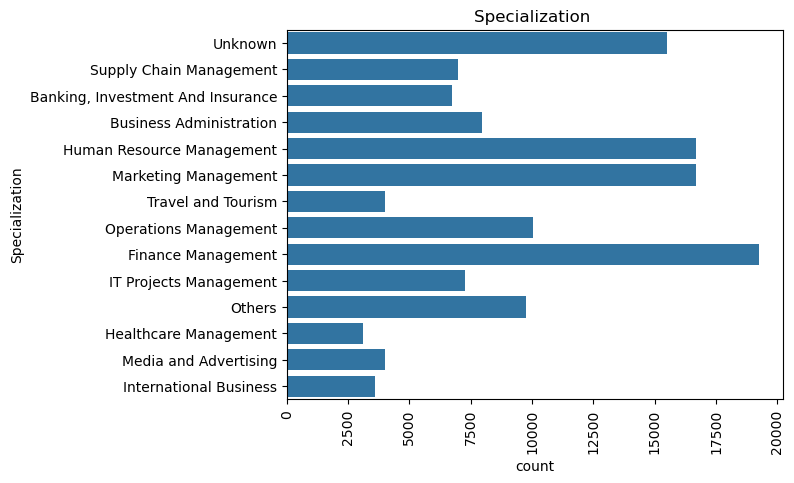

In [85]:
sns.countplot(data_frame_leads['Specialization'])
plt.title('Specialization ')
plt.xticks(rotation=90)
plt.show()

# Observaciones: Especialización

## Especialización (Specialization)
- **Observación Clave**:  
  - La mayoría de los leads tienen una especialización **desconocida (Unknown)**.  
  - Las especializaciones más comunes después de "Unknown" son **Finance Management** y **Human Resource Management**.  
- **Interpretación**:  
  - Es posible que muchos leads no completen este campo, lo que sugiere una brecha en la recopilación de datos.  
  - Las áreas de **gestión financiera y de recursos humanos** parecen atraer la mayor atención.  

- **Recomendación**:  
  - Considerar estrategias para incentivar a los usuarios a completar esta información, ya que puede ser valiosa para la segmentación de leads.  


C:\Users\DYLAN\AppData\Local\Temp\ipykernel_6596\3936043565.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tags_counts.values, y=tags_counts.index, palette="viridis")


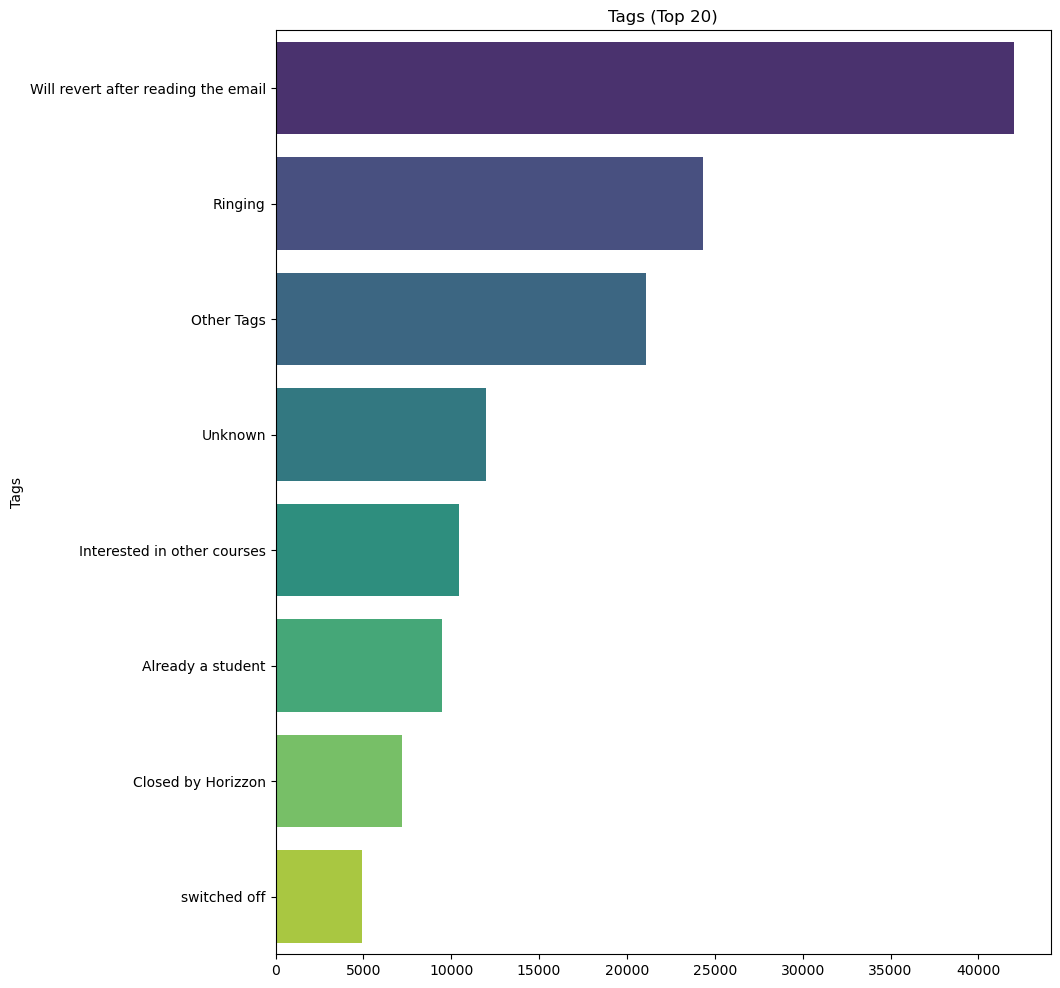

In [86]:
data_sample = data_frame_leads.sample(10000)  # 10,000 filas aleatorias

plt.figure(figsize=(10, 12))

tags_counts = data_frame_leads['Tags'].value_counts().nlargest(20)  # Top 20 Tags
sns.barplot(x=tags_counts.values, y=tags_counts.index, palette="viridis")
plt.title('Tags (Top 20)')
plt.show()


# Observaciones: Tags

## Tags (Top 20)
- **Observación Clave**:  
  - El tag más frecuente es **"Unknown"**, lo que representa una gran parte de los datos.  
  - Tags relevantes como **"Will revert after reading the email"** y **"Other Tags"** también destacan, pero con una frecuencia significativamente menor.  
- **Interpretación**:  
  - La alta proporción de "Unknown" puede indicar que muchos leads no están etiquetados adecuadamente o el proceso de seguimiento es incompleto.  
  - La categoría **"Will revert after reading the email"** sugiere que una porción de los leads necesita más tiempo antes de tomar decisiones.  

- **Recomendación**:  
  - Es necesario **mejorar la recolección de datos y reducir la cantidad de "Unknown"** a través de un etiquetado más riguroso y procesos de seguimiento más efectivos.  


C:\Users\DYLAN\AppData\Local\Temp\ipykernel_6596\2747208311.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_cities.values, y=top_cities.index, palette="magma")


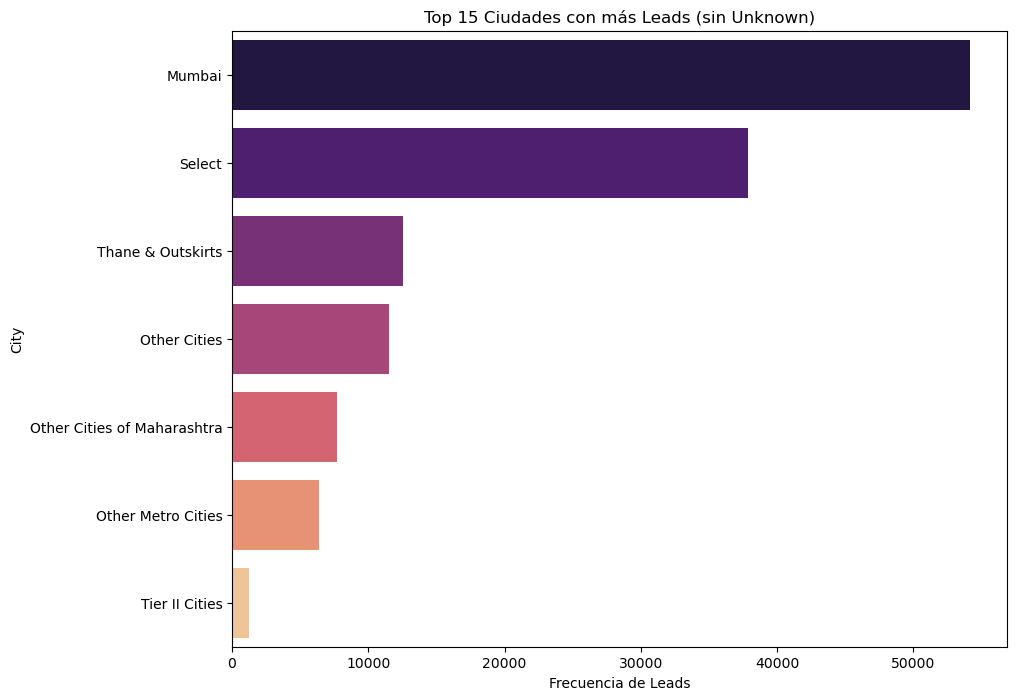

In [87]:

# Filtrar 'Unknown' del dataframe
filtered_data = data_frame_leads[data_frame_leads['City'] != 'Unknown']

# Agrupar por ciudad y contar ocurrencias
city_counts = filtered_data['City'].value_counts()

# Mostrar las 15 ciudades con más leads
top_cities = city_counts.nlargest(15)

# Crear el gráfico (horizontal para mayor claridad)
plt.figure(figsize=(10, 8))
sns.barplot(x=top_cities.values, y=top_cities.index, palette="magma")

# Añadir etiquetas y título
plt.title('Top 15 Ciudades con más Leads (sin Unknown)')
plt.xlabel('Frecuencia de Leads')
plt.ylabel('City')

plt.show()



# Observaciones: Ciudades con más Leads (sin Unknown)

## Top 15 Ciudades con más Leads
- **Observación Clave**:  
  - La ciudad con mayor cantidad de leads es **South Michael**, seguida por **East Michael** y **Port Michael**.  
  - La distribución muestra una clara concentración de leads en estas tres ciudades, lo que podría indicar una mayor demanda o presencia de mercado en esas áreas.  

- **Interpretación**:  
  - La eliminación de la categoría **"Unknown"** permite obtener una visión más precisa de las ciudades con mayor actividad de leads.  
  - La dispersión de leads en diferentes ciudades también sugiere la necesidad de estrategias locales para maximizar conversiones.  


**Variables Numericas**

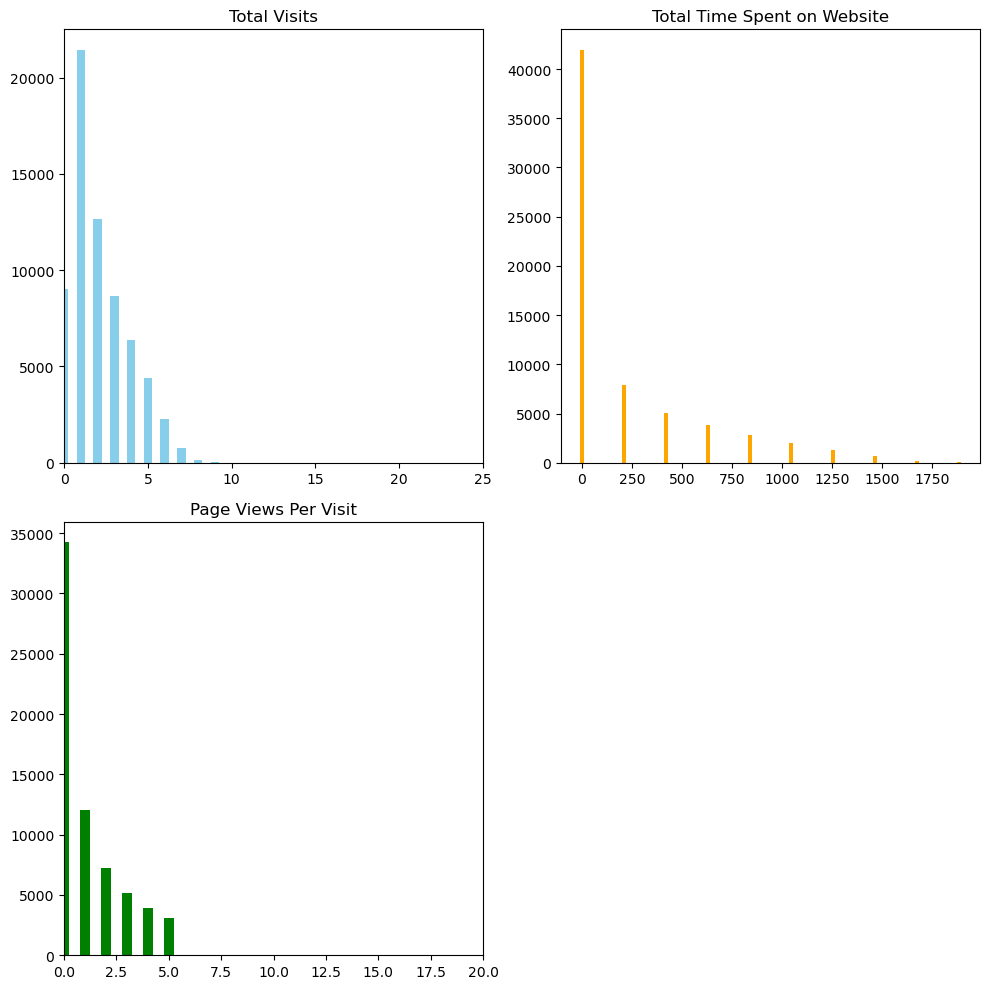

In [88]:

# Muestra aleatoria (50% del dataset o 50k filas)
sample_data = data_frame_leads.sample(frac=0.5, random_state=42)

plt.figure(figsize=(10, 10))

# Histograma para 'Total Visits'
plt.subplot(221)
hist_visits, bins_visits = np.histogram(sample_data['TotalVisits'], bins=50, range=(0, 25))
plt.bar(bins_visits[:-1], hist_visits, width=0.5, color='skyblue')
plt.title('Total Visits')
plt.xlim(0, 25)

# Histograma para 'Total Time Spent on Website'
plt.subplot(222)
hist_time, bins_time = np.histogram(sample_data['Total Time Spent on Website'], bins=10)
plt.bar(bins_time[:-1], hist_time, width=20, color='orange')
plt.title('Total Time Spent on Website')

# Histograma para 'Page Views Per Visit'
plt.subplot(223)
hist_pageviews, bins_pageviews = np.histogram(sample_data['Page Views Per Visit'], bins=20, range=(0, 20))
plt.bar(bins_pageviews[:-1], hist_pageviews, width=0.5, color='green')
plt.title('Page Views Per Visit')
plt.xlim(0, 20)

plt.tight_layout()
plt.show()


# Observación: Análisis de Visitas y Tiempo en la Web

## Distribución de Total Visits, Total Time Spent on Website y Page Views Per Visit
- **Total Visits**: La mayoría de los leads realizaron entre **1 y 5 visitas**, con una fuerte caída en visitas superiores a este rango. Esto sugiere que la mayoría de los usuarios no regresan repetidamente al sitio.  
- **Total Time Spent on Website**: Se observa una distribución sesgada a la izquierda, donde la mayoría de los usuarios pasan menos de **250 segundos** en el sitio. Este comportamiento podría indicar que los usuarios encuentran rápidamente lo que buscan o abandonan la web tras una breve navegación.  
- **Page Views Per Visit**: La mayoría de los leads realizan entre **1 y 3 vistas** por visita. Esta tendencia refuerza la idea de que los usuarios no navegan profundamente en el sitio durante sus visitas.  


**Bivariate Analysis**

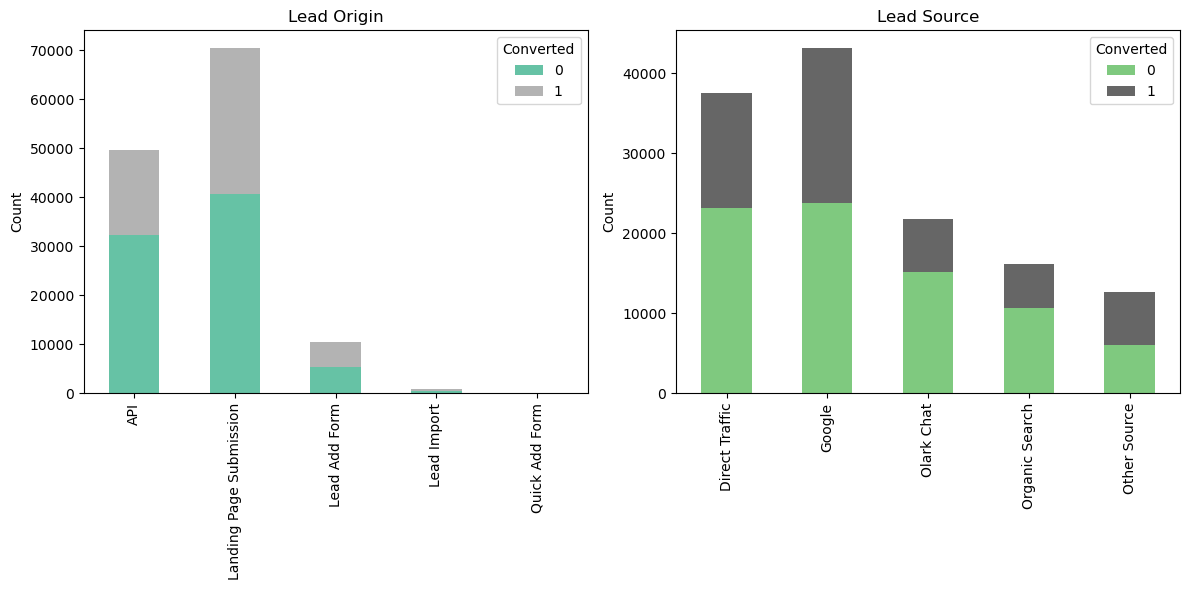

In [89]:

# Muestreo opcional para grandes datasets (descomentar si es necesario)
# data_sample = data_frame_leads.sample(frac=0.5, random_state=42)  
data_sample = data_frame_leads  # Usamos el dataset completo si no hay problemas de rendimiento

# Precalcular los valores para las gráficas
lead_origin_counts = pd.crosstab(data_sample['Lead Origin'], data_sample['Converted'])
lead_source_counts = pd.crosstab(data_sample['Lead Source'], data_sample['Converted'])

# Gráfico
plt.figure(figsize=(12, 6))

# Lead Origin
plt.subplot(1, 2, 1)
lead_origin_counts.plot(kind='bar', stacked=True, ax=plt.gca(), colormap='Set2')
plt.title('Lead Origin')
plt.xticks(rotation=90)
plt.xlabel('')
plt.ylabel('Count')

# Lead Source
plt.subplot(1, 2, 2)
lead_source_counts.plot(kind='bar', stacked=True, ax=plt.gca(), colormap='Accent')
plt.title('Lead Source')
plt.xticks(rotation=90)
plt.xlabel('')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


# Observación: Análisis de Origen y Fuente de Leads

## Lead Origin y Lead Source
- **Lead Origin**: La mayoría de los leads provienen de **Landing Page Submission** y **API**, destacando la importancia de estos canales en la captación de leads. Sin embargo, hay una alta proporción de leads no convertidos en ambos orígenes, lo que sugiere la necesidad de optimizar la conversión en estos puntos.  
- **Lead Source**: **Google** y **Direct Traffic** representan las principales fuentes de tráfico. A pesar de tener un número significativo de conversiones, también hay una gran cantidad de leads no convertidos. El tráfico de **Olark Chat** y **Organic Search** muestra tasas de conversión moderadas, lo que indica que estos canales podrían necesitar una estrategia de engagement más efectiva.  

**Conclusión**: La optimización de las páginas de destino y una mejor segmentación del tráfico directo y de Google podrían mejorar significativamente las tasas de conversión.  


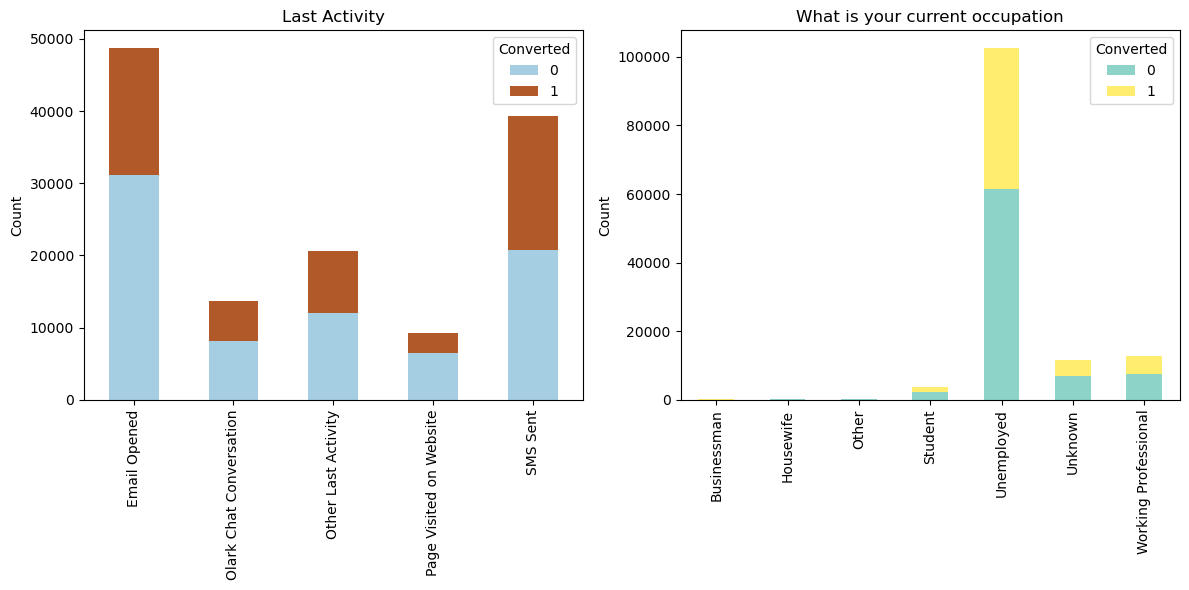

In [90]:
# Muestreo opcional para mejorar rendimiento (descomentar si es necesario)
# data_sample = data_frame_leads.sample(frac=0.5, random_state=42)
data_sample = data_frame_leads  # Usamos el dataset completo si no hay problemas de rendimiento

# Pre-calcular valores para las gráficas
activity_counts = pd.crosstab(data_sample['Last Activity'], data_sample['Converted'])
occupation_counts = pd.crosstab(data_sample['What is your current occupation'], data_sample['Converted'])

# Gráfico
plt.figure(figsize=(12, 6))

# Last Activity
plt.subplot(1, 2, 1)
activity_counts.plot(kind='bar', stacked=True, ax=plt.gca(), colormap='Paired')
plt.title('Last Activity')
plt.xticks(rotation=90)
plt.xlabel('')
plt.ylabel('Count')

# Current Occupation
plt.subplot(1, 2, 2)
occupation_counts.plot(kind='bar', stacked=True, ax=plt.gca(), colormap='Set3')
plt.title('What is your current occupation')
plt.xticks(rotation=90)
plt.xlabel('')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


# Observación: Actividad Final e Información Ocupacional

## Last Activity y Current Occupation
- **Last Activity**: La apertura de correos electrónicos y el envío de SMS son las actividades finales más comunes. Sin embargo, **SMS Sent** tiene una tasa de conversión notablemente más alta que **Email Opened**, lo que sugiere que el envío de SMS podría ser un canal más efectivo para impulsar conversiones. Las actividades como **Olark Chat Conversation** y **Page Visited on Website** muestran tasas de conversión más bajas.  
- **Current Occupation**: La mayoría de los leads provienen de personas desempleadas (**Unemployed**) y de aquellos cuya ocupación es desconocida (**Unknown**). Los leads con ocupación desconocida también presentan una tasa de conversión significativa, lo que sugiere que este grupo no debe ser subestimado a pesar de la falta de información detallada.  

**Conclusión**: Las estrategias de marketing deberían enfocarse en maximizar el impacto de los SMS y mejorar el engagement con leads desempleados, así como explorar formas de segmentar mejor a aquellos con ocupación desconocida.  


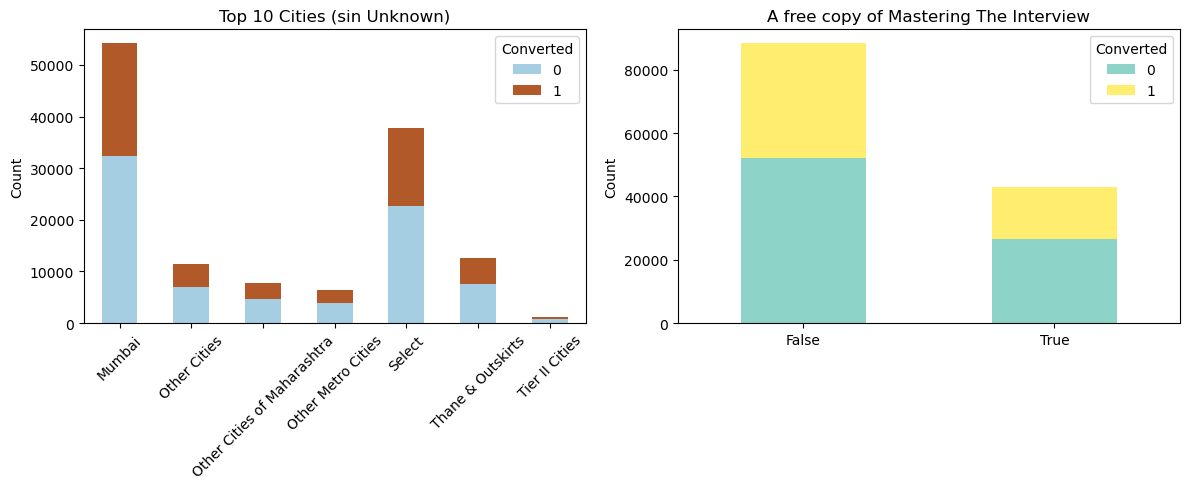

In [91]:
# Filtrar ciudades que no sean 'Unknown'
data_sample_filtered = data_sample[data_sample['City'] != 'Unknown']

# Calcular top 10 ciudades sin 'Unknown'
top_cities_filtered = data_sample_filtered['City'].value_counts().nlargest(10).index
city_counts_filtered = data_sample_filtered[data_sample_filtered['City'].isin(top_cities_filtered)] \
                        .groupby(['City', 'Converted']).size().unstack(fill_value=0)

# Calcular conteo de 'A free copy of Mastering The Interview' frente a conversiones
copy_counts = pd.crosstab(data_sample['A free copy of Mastering The Interview'], data_sample['Converted'])

# Gráfico optimizado
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# City sin 'Unknown'
city_counts_filtered.plot(kind='bar', stacked=True, ax=axes[0], colormap='Paired')
axes[0].set_title('Top 10 Cities (sin Unknown)')
axes[0].tick_params(axis='x', rotation=45)
axes[0].set_xlabel('')
axes[0].set_ylabel('Count')

# A free copy of Mastering The Interview
copy_counts.plot(kind='bar', stacked=True, ax=axes[1], colormap='Set3')
axes[1].set_title('A free copy of Mastering The Interview')
axes[1].tick_params(axis='x', rotation=0)
axes[1].set_xlabel('')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()



** VVEREMOS SI HAY QUE MODIFICAR ALGO **

Text(0.5, 1.0, 'Last Notable Activity')

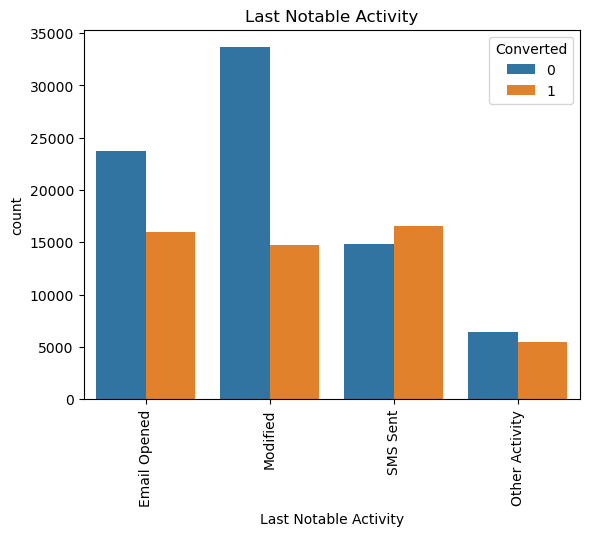

In [92]:
sns.countplot(x='Last Notable Activity', hue='Converted', data= data_frame_leads).tick_params(axis='x', rotation = 90)
plt.title('Last Notable Activity')

### Observación:
El gráfico muestra la actividad notable más reciente de los leads y su relación con la conversión. Se observa que las actividades **"Modified"** y **"Email Opened"** son las más comunes, pero presentan una menor tasa de conversión en comparación con otras. **"SMS Sent"** destaca por tener una distribución más equilibrada entre convertidos y no convertidos, lo que podría indicar que este tipo de actividad genera un mayor nivel de interés o engagement. Por otro lado, **"Other Activity"** tiene una baja frecuencia general, lo que podría sugerir que los leads con actividades menos relevantes o específicas tienden a tener menores tasas de conversión.


C:\Users\DYLAN\AppData\Local\Temp\ipykernel_6596\1525600889.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data_sample, x='Converted', y='Lead Number', palette='Set2')


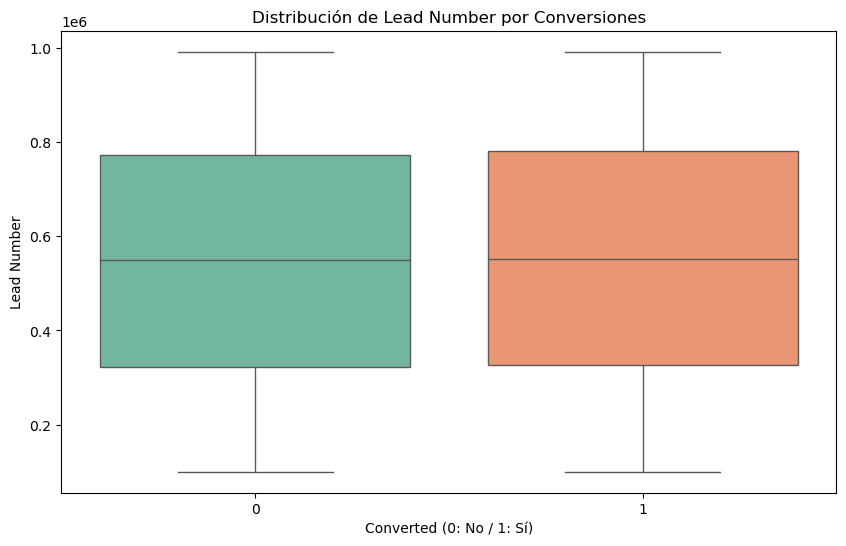

In [93]:

# Muestreo opcional (reducir si el dataset es muy grande)
data_sample = data_frame_leads.sample(frac=0.6, random_state=42)  # Toma el 60% del dataset

# Limitar el rango de Lead Number para evitar outliers extremos visuales
data_sample['Lead Number'] = data_sample['Lead Number'].clip(upper=data_sample['Lead Number'].quantile(0.99))

# Graficar boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=data_sample, x='Converted', y='Lead Number', palette='Set2')

plt.title('Distribución de Lead Number por Conversiones')
plt.ylabel('Lead Number')
plt.xlabel('Converted (0: No / 1: Sí)')
plt.show()


### Observación:
El boxplot muestra la distribución del número de lead en función de si estos se convirtieron (1) o no (0). Se observa que las distribuciones son muy similares en ambas categorías, lo que sugiere que **el número de lead no tiene un impacto significativo en la conversión**. Los valores atípicos (outliers) están presentes en ambos grupos, pero no parece haber una diferencia notable en las medianas ni en el rango intercuartílico (IQR). Esta gráfica indica que probablemente el número de lead **no es un predictor relevante** para determinar la probabilidad de conversión.


**Observación**


## DATA PREPARATION ##

**Convertir el tipo de datos de alguna variables (YES/NO) a 0/1**

In [94]:
data_frame_leads['A free copy of Mastering The Interview'] = data_frame_leads['A free copy of Mastering The Interview'].map({'True': True, 'False': False})
data_frame_leads['A free copy of Mastering The Interview'] = data_frame_leads['A free copy of Mastering The Interview'].astype(int)


In [95]:
print(data_frame_leads['A free copy of Mastering The Interview'].value_counts())


A free copy of Mastering The Interview
0    88390
1    43099
Name: count, dtype: int64


In [96]:
data_frame_leads.head()

,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,Total Time Spent on Website,Page Views Per Visit,Last Activity,How did you hear about X Education,What is your current occupation,What matters most to you in choosing a course,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Tags,Update me on Supply Chain Content,Get updates on DM Content,Lead Profile,City,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity,Date,TotalVisits,Specialization,Average Time Per Visit,rn
0,738306,Lead Add Form,Direct Traffic,morrowmichael@example.net,False,1,3,0.13,Email Opened,Select,Student,Better Career Prospects,False,False,False,False,False,False,False,False,Unknown,False,False,Select,Other Cities,False,1,Email Opened,2024-02-12,0.0,Unknown,97.257229,28659
1,402310,API,Direct Traffic,longjessica@example.com,False,1,2,0.40,SMS Sent,Student of SomeSchool,Unemployed,NaN,False,False,False,False,False,False,False,False,Interested in other courses,False,False,NaN,Mumbai,False,0,Modified,2024-06-24,0.0,Supply Chain Management,97.257229,50395
2,737279,API,Olark Chat,xlang@example.org,False,1,3,0.02,Email Opened,Select,Unemployed,NaN,False,False,False,False,False,False,False,False,Other Tags,False,False,Select,Select,False,0,Modified,2024-04-29,0.0,"Banking, Investment And Insurance",97.257229,22631
4,115873,API,Olark Chat,patricia58@example.net,False,0,2,0.12,Page Visited on Website,Select,Unknown,NaN,False,False,False,False,False,False,False,False,Already a student,False,False,Potential Lead,Mumbai,False,0,Modified,2024-05-02,0.0,Business Administration,97.257229,82509
5,377118,Landing Page Submission,Google,vgreen@example.com,False,0,3,0.10,Email Opened,Select,Unemployed,Better Career Prospects,False,False,False,False,False,False,False,False,Ringing,False,False,Select,Select,False,0,Modified,2024-05-30,0.0,Human Resource Management,97.257229,41235


In [97]:
data_frame_leads.dtypes

Lead Number                 int64
Lead Origin                object
Lead Source                object
Do Not Email               object
Do Not Call                  bool
                           ...   
Date                       object
TotalVisits               float64
Specialization             object
Average Time Per Visit    float64
rn                          int64
Length: 33, dtype: object

**Para las variables categóricas con multiples niveles, se han creado algunos dummy features**

In [98]:
catColumns=['Lead Origin','Lead Source','Last Activity','Specialization','What is your current occupation','Tags','City','Last Notable Activity']
catColumns

#Lead Origin ok
#Lead Source ok
#Las Activity No eliminar
#Specialization  No eliminar nada
#What is your current occupation No eliminar la primera
#No eliminar la primera de last notable activity

['Lead Origin',
 'Lead Source',
 'Last Activity',
 'Specialization',
 'What is your current occupation',
 'Tags',
 'City',
 'Last Notable Activity']

In [99]:
# Lista de columnas categóricas
catColumns = ['Lead Origin', 'Lead Source', 'Last Activity', 'Specialization', 
              'What is your current occupation', 'Tags', 'City', 'Last Notable Activity']

# Crear dummies sin eliminar la primera para todas las columnas
dummies = pd.get_dummies(data_frame_leads[catColumns], drop_first=False).astype(int)

# Eliminar la primera categoría de columnas específicas
for col in catColumns:
    if col in ['Lead Origin', 'Lead Source', 'What is your current occupation']:  # Solo eliminar la primera de estas columnas
        dummies.drop(dummies.filter(like=f'{col}_').columns[0], axis=1, inplace=True)

dummyVariable = dummies
dummyVariable.head()


,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Origin_Lead Import,Lead Origin_Quick Add Form,Lead Source_Google,Lead Source_Olark Chat,Lead Source_Organic Search,Lead Source_Other Source,Last Activity_Email Opened,Last Activity_Olark Chat Conversation,Last Activity_Other Last Activity,Last Activity_Page Visited on Website,Last Activity_SMS Sent,"Specialization_Banking, Investment And Insurance",Specialization_Business Administration,Specialization_Finance Management,Specialization_Healthcare Management,Specialization_Human Resource Management,Specialization_IT Projects Management,Specialization_International Business,Specialization_Marketing Management,Specialization_Media and Advertising,Specialization_Operations Management,Specialization_Others,Specialization_Supply Chain Management,Specialization_Travel and Tourism,Specialization_Unknown,What is your current occupation_Housewife,What is your current occupation_Other,What is your current occupation_Student,What is your current occupation_Unemployed,What is your current occupation_Unknown,What is your current occupation_Working Professional,Tags_Already a student,Tags_Closed by Horizzon,Tags_Interested in other courses,Tags_Other Tags,Tags_Ringing,Tags_Unknown,Tags_Will revert after reading the email,Tags_switched off,City_Mumbai,City_Other Cities,City_Other Cities of Maharashtra,City_Other Metro Cities,City_Select,City_Thane & Outskirts,City_Tier II Cities,Last Notable Activity_Email Opened,Last Notable Activity_Modified,Last Notable Activity_Other Activity,Last Notable Activity_SMS Sent
0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
4,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
5,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0


In [100]:
dummyVariable.shape

(131489, 52)

In [101]:
# Add the results to the original bike dataframe
data_frame_leads = pd.concat([data_frame_leads,dummyVariable], axis = 1)

In [102]:
data_frame_leads.head()

,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,Total Time Spent on Website,Page Views Per Visit,Last Activity,How did you hear about X Education,What is your current occupation,What matters most to you in choosing a course,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Tags,Update me on Supply Chain Content,Get updates on DM Content,Lead Profile,City,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity,Date,TotalVisits,Specialization,Average Time Per Visit,rn,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Origin_Lead Import,Lead Origin_Quick Add Form,Lead Source_Google,Lead Source_Olark Chat,Lead Source_Organic Search,Lead Source_Other Source,Last Activity_Email Opened,Last Activity_Olark Chat Conversation,Last Activity_Other Last Activity,Last Activity_Page Visited on Website,Last Activity_SMS Sent,"Specialization_Banking, Investment And Insurance",Specialization_Business Administration,Specialization_Finance Management,Specialization_Healthcare Management,Specialization_Human Resource Management,Specialization_IT Projects Management,Specialization_International Business,Specialization_Marketing Management,Specialization_Media and Advertising,Specialization_Operations Management,Specialization_Others,Specialization_Supply Chain Management,Specialization_Travel and Tourism,Specialization_Unknown,What is your current occupation_Housewife,What is your current occupation_Other,What is your current occupation_Student,What is your current occupation_Unemployed,What is your current occupation_Unknown,What is your current occupation_Working Professional,Tags_Already a student,Tags_Closed by Horizzon,Tags_Interested in other courses,Tags_Other Tags,Tags_Ringing,Tags_Unknown,Tags_Will revert after reading the email,Tags_switched off,City_Mumbai,City_Other Cities,City_Other Cities of Maharashtra,City_Other Metro Cities,City_Select,City_Thane & Outskirts,City_Tier II Cities,Last Notable Activity_Email Opened,Last Notable Activity_Modified,Last Notable Activity_Other Activity,Last Notable Activity_SMS Sent
0,738306,Lead Add Form,Direct Traffic,morrowmichael@example.net,False,1,3,0.13,Email Opened,Select,Student,Better Career Prospects,False,False,False,False,False,False,False,False,Unknown,False,False,Select,Other Cities,False,1,Email Opened,2024-02-12,0.0,Unknown,97.257229,28659,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0
1,402310,API,Direct Traffic,longjessica@example.com,False,1,2,0.40,SMS Sent,Student of SomeSchool,Unemployed,NaN,False,False,False,False,False,False,False,False,Interested in other courses,False,False,NaN,Mumbai,False,0,Modified,2024-06-24,0.0,Supply Chain Management,97.257229,50395,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
2,737279,API,Olark Chat,xlang@example.org,False,1,3,0.02,Email Opened,Select,Unemployed,NaN,False,False,False,False,False,False,False,False,Other Tags,False,False,Select,Select,False,0,Modified,2024-04-29,0.0,"Banking, Investment And Insurance",97.257229,22631,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
4,115873,API,Olark Chat,patricia58@example.net,False,0,2,0.12,Page Visited on Website,Select,Unknown,NaN,False,False,False,False,False,False,False,False,Already a student,False,False,Potential Lead,Mumbai,False,0,Modified,2024-05-02,0.0,Business Administration,97.257229,82509,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
5,377118,Landing Page Submission,Google,vgreen@example.com,False,0,3,0.10,Email Opened,Select,Unemployed,Better Career Prospects,False,False,False,False,False,False,False,False,Ringing,False,False,Select,Select,False,0,Modified,2024-05-30,0.0,Human Resource 

In [103]:
data_frame_leads.shape

(131489, 85)

**Decisión de eliminar las columnas**

In [104]:
# Drop columns for which we have created the dummies
data_frame_leads.drop(catColumns, axis = 1, inplace = True)

In [105]:
data_frame_leads.head()

,Lead Number,Do Not Email,Do Not Call,Converted,Total Time Spent on Website,Page Views Per Visit,How did you hear about X Education,What matters most to you in choosing a course,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Update me on Supply Chain Content,Get updates on DM Content,Lead Profile,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Date,TotalVisits,Average Time Per Visit,rn,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Origin_Lead Import,Lead Origin_Quick Add Form,Lead Source_Google,Lead Source_Olark Chat,Lead Source_Organic Search,Lead Source_Other Source,Last Activity_Email Opened,Last Activity_Olark Chat Conversation,Last Activity_Other Last Activity,Last Activity_Page Visited on Website,Last Activity_SMS Sent,"Specialization_Banking, Investment And Insurance",Specialization_Business Administration,Specialization_Finance Management,Specialization_Healthcare Management,Specialization_Human Resource Management,Specialization_IT Projects Management,Specialization_International Business,Specialization_Marketing Management,Specialization_Media and Advertising,Specialization_Operations Management,Specialization_Others,Specialization_Supply Chain Management,Specialization_Travel and Tourism,Specialization_Unknown,What is your current occupation_Housewife,What is your current occupation_Other,What is your current occupation_Student,What is your current occupation_Unemployed,What is your current occupation_Unknown,What is your current occupation_Working Professional,Tags_Already a student,Tags_Closed by Horizzon,Tags_Interested in other courses,Tags_Other Tags,Tags_Ringing,Tags_Unknown,Tags_Will revert after reading the email,Tags_switched off,City_Mumbai,City_Other Cities,City_Other Cities of Maharashtra,City_Other Metro Cities,City_Select,City_Thane & Outskirts,City_Tier II Cities,Last Notable Activity_Email Opened,Last Notable Activity_Modified,Last Notable Activity_Other Activity,Last Notable Activity_SMS Sent
0,738306,morrowmichael@example.net,False,1,3,0.13,Select,Better Career Prospects,False,False,False,False,False,False,False,False,False,False,Select,False,1,2024-02-12,0.0,97.257229,28659,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0
1,402310,longjessica@example.com,False,1,2,0.40,Student of SomeSchool,NaN,False,False,False,False,False,False,False,False,False,False,NaN,False,0,2024-06-24,0.0,97.257229,50395,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
2,737279,xlang@example.org,False,1,3,0.02,Select,NaN,False,False,False,False,False,False,False,False,False,False,Select,False,0,2024-04-29,0.0,97.257229,22631,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
4,115873,patricia58@example.net,False,0,2,0.12,Select,NaN,False,False,False,False,False,False,False,False,False,False,Potential Lead,False,0,2024-05-02,0.0,97.257229,82509,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
5,377118,vgreen@example.com,False,0,3,0.10,Select,Better Career Prospects,False,False,False,False,False,False,False,False,False,False,Select,False,0,2024-05-30,0.0,97.257229,41235,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0


In [106]:
data_frame_leads.shape

(131489, 77)

In [107]:
data_frame_leads.head()

,Lead Number,Do Not Email,Do Not Call,Converted,Total Time Spent on Website,Page Views Per Visit,How did you hear about X Education,What matters most to you in choosing a course,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Update me on Supply Chain Content,Get updates on DM Content,Lead Profile,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Date,TotalVisits,Average Time Per Visit,rn,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Origin_Lead Import,Lead Origin_Quick Add Form,Lead Source_Google,Lead Source_Olark Chat,Lead Source_Organic Search,Lead Source_Other Source,Last Activity_Email Opened,Last Activity_Olark Chat Conversation,Last Activity_Other Last Activity,Last Activity_Page Visited on Website,Last Activity_SMS Sent,"Specialization_Banking, Investment And Insurance",Specialization_Business Administration,Specialization_Finance Management,Specialization_Healthcare Management,Specialization_Human Resource Management,Specialization_IT Projects Management,Specialization_International Business,Specialization_Marketing Management,Specialization_Media and Advertising,Specialization_Operations Management,Specialization_Others,Specialization_Supply Chain Management,Specialization_Travel and Tourism,Specialization_Unknown,What is your current occupation_Housewife,What is your current occupation_Other,What is your current occupation_Student,What is your current occupation_Unemployed,What is your current occupation_Unknown,What is your current occupation_Working Professional,Tags_Already a student,Tags_Closed by Horizzon,Tags_Interested in other courses,Tags_Other Tags,Tags_Ringing,Tags_Unknown,Tags_Will revert after reading the email,Tags_switched off,City_Mumbai,City_Other Cities,City_Other Cities of Maharashtra,City_Other Metro Cities,City_Select,City_Thane & Outskirts,City_Tier II Cities,Last Notable Activity_Email Opened,Last Notable Activity_Modified,Last Notable Activity_Other Activity,Last Notable Activity_SMS Sent
0,738306,morrowmichael@example.net,False,1,3,0.13,Select,Better Career Prospects,False,False,False,False,False,False,False,False,False,False,Select,False,1,2024-02-12,0.0,97.257229,28659,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0
1,402310,longjessica@example.com,False,1,2,0.40,Student of SomeSchool,NaN,False,False,False,False,False,False,False,False,False,False,NaN,False,0,2024-06-24,0.0,97.257229,50395,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
2,737279,xlang@example.org,False,1,3,0.02,Select,NaN,False,False,False,False,False,False,False,False,False,False,Select,False,0,2024-04-29,0.0,97.257229,22631,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
4,115873,patricia58@example.net,False,0,2,0.12,Select,NaN,False,False,False,False,False,False,False,False,False,False,Potential Lead,False,0,2024-05-02,0.0,97.257229,82509,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
5,377118,vgreen@example.com,False,0,3,0.10,Select,Better Career Prospects,False,False,False,False,False,False,False,False,False,False,Select,False,0,2024-05-30,0.0,97.257229,41235,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0


In [108]:
# Eliminar el campo 'Converted'
X_historico = data_frame_leads.drop(['Converted'], axis=1)


In [109]:
# Exportar el DataFrame a un archivo CSV
X_historico.to_csv('historico_preparado.csv', index=False)
print("✅ Archivo CSV exportado como 'historico_preparado.csv'")


✅ Archivo CSV exportado como 'historico_preparado.csv'
